In [1]:
!pip install umap-learn
!pip install scikit-learn==1.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.9 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=a598391649875bf187ed87b9cfb60462725bc0791f6ad2162298d134b92d8492
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 90.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
# import packages and define useful functions
import re
import pickle

import numpy as np
import pandas as pd
from tqdm import tqdm
import umap.umap_ as umap
import plotly.express as px
from plotmat import plot_mat
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.datasets import fetch_20newsgroups
from scipy.optimize import linear_sum_assignment
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.cluster import contingency_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import AgglomerativeClustering, HDBSCAN
from sklearn.metrics.cluster import homogeneity_score, \
    completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score


def plot_5_measure_scores(method, r, homo_score, comp_score, v_score, ar_score, ami_score):
    """
    This function plots 5 measurements.
    """
    plt.plot(homo_score, "blue", label="Homogeneity score")
    plt.plot(comp_score, "red", label="Completeness score")
    plt.plot(v_score, "fuchsia", label="V-measure score")
    plt.plot(ar_score,"darkolivegreen",label="Adjusted Rand score")
    plt.plot(ami_score,"darkorange",label="Adjusted mutual information score")

    plt.legend()
    plt.xlabel("r");
    plt.xticks(np.arange(len(r)),r)
    plt.ylabel("scores measured");
    plt.title(f"5 measure scores for {method}")
    plt.grid()


def get_dense_representation(X_sparse, DimReduceMethod, r=5):
    """
    This function generates a dense data representation by different methods, i.e.,
    "None", "SVD", "NMF", and "UMAP".
    """
    # Dimension Reduction
    if DimReduceMethod == "None":
        X_dense = X_sparse
    elif DimReduceMethod == "SVD":
        svd = TruncatedSVD(n_components=r, n_iter=7, random_state=random_seed)
        X_dense = svd.fit_transform(X_sparse)
    elif DimReduceMethod == "NMF":
        nmf = NMF(n_components=r, init="random", max_iter=500, random_state=random_seed)
        X_dense = nmf.fit_transform(X_sparse)
    elif DimReduceMethod == "UMAP":
        u_map = umap.UMAP(n_components=r, metric="cosine")
        X_dense = u_map.fit_transform(X_sparse)
    else:
        raise SystemExit("Please enter a valid Dimension Reduction Method!")

    return X_dense

def get_preds(X_dense, ClusteringMethod, k=10, num_clusters=20, mini_cluster_size=100):
    """
    This function generates clustering predictions of the (dense) data by different methods, i.e.,
    "K-Means", "Agglomerative Clustering", and "HDBSCAN".
    """
    # Clustering
    if ClusteringMethod == "K-Means":
        kmeans = KMeans(n_clusters=k,
                random_state=0,
                max_iter=2000,
                n_init=60)
        kmeans.fit(X_dense)
        preds = kmeans.labels_
    elif ClusteringMethod == "Agglomerative Clustering":
        agg = AgglomerativeClustering(n_clusters=num_clusters)
        preds = agg.fit_predict(X_dense)
    elif ClusteringMethod == "HDBSCAN":
        hdbscan = HDBSCAN(min_cluster_size=mini_cluster_size,
                          min_samples=2,
                          cluster_selection_epsilon=0.01)
        preds = hdbscan.fit_predict(X_dense)
    else:
        raise SystemExit("Please enter a valid Clustering Method!")

    return preds


def get_ScoreAvg(class_labels, preds): # class_labels obtained in Question 10
    """
    This function calculates the average of the five metrics given ground-trueth
    class labels and predictions.
    """
    homo_score = homogeneity_score(class_labels, preds)
    comp_score = completeness_score(class_labels, preds)
    v_measure = v_measure_score(class_labels, preds)
    rand_index = adjusted_rand_score(class_labels, preds)
    mutual_info_score = adjusted_mutual_info_score(class_labels, preds)

    ScoreAvg = np.mean(np.array([homo_score,
                                 comp_score,
                                 v_measure,
                                 rand_index,
                                 mutual_info_score]))

    return ScoreAvg


random_seed = 42


### <strong>Question 1</strong>
<p>The dimension of the TF-IDF matrix obtained is (7882, 23522).</p>

In [ ]:
classes = ["comp.graphics", "comp.os.ms-windows.misc", "comp.sys.ibm.pc.hardware", "comp.sys.mac.hardware", \
           "rec.autos", "rec.motorcycles", "rec.sport.baseball", "rec.sport.hockey"]

class_1 = ["comp.graphics", "comp.os.ms-windows.misc", "comp.sys.ibm.pc.hardware", "comp.sys.mac.hardware"]

class_2 = ["rec.autos", "rec.motorcycles", "rec.sport.baseball", "rec.sport.hockey"]

twenty_news_subset = fetch_20newsgroups(subset='all',
                                        remove=("headers", "footers"),
                                        categories=classes,
                                        shuffle=True,
                                        random_state=random_seed)

class_labels = twenty_news_subset.target # 0~7 indicating class index

TFIDF_transformer = TfidfTransformer()
count_vect = CountVectorizer(stop_words='english', min_df=3)
X_counts = count_vect.fit_transform(twenty_news_subset.data)
X_tfidf = TFIDF_transformer.fit_transform(X_counts)
print(f"shape of the TF-IDF matrix obtained:\n{X_tfidf.shape}")

pass

shape of the TF-IDF matrix obtained:
(7882, 23522)


### <strong>Question 2</strong><br>
The Contingency Table is
$$
\begin{bmatrix}
680 & 3223 \\
3924 & 55
\end{bmatrix}
$$
as shown below along with the visualization. In this binary classification, true labels are either 0 or 1 so as predicted labels. So, the shape of the Contingency Table is (2, 2) and it is square.

the contingency matrix generated:
[[ 680 3223]
 [3924   55]]


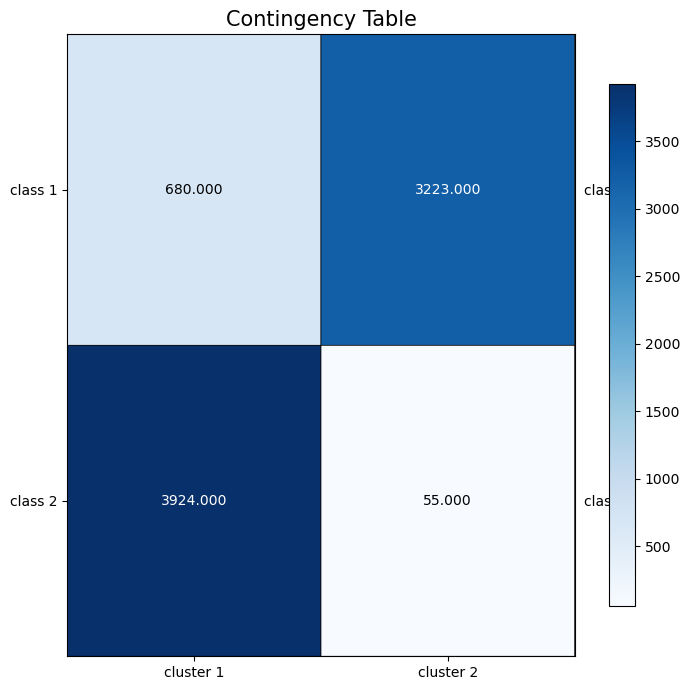

In [ ]:
k_ = 2

kmeans = KMeans(n_clusters=k_,
                random_state=0,
                max_iter=2000,
                n_init=60).fit(X_tfidf)

cluster_labels = kmeans.labels_

# return binary labels, where "0" indicating class_1 and "1" indicating class_2
class_binary_labels = [int(i/4) for i in class_labels]

contg_table = contingency_matrix(labels_true=class_binary_labels, labels_pred=cluster_labels)

print(f"the contingency matrix generated:\n{contg_table}\n")
plot_mat(mat=contg_table,
         xticklabels=["cluster 1","cluster 2"],
         yticklabels=["class 1","class 2"],
         title = "Contingency Table",
         size=(7, 7))

pass

### <strong>Question 3</strong>
<p>The 5 clustering measures are reported in the cell below.</p>

In [ ]:
homo_score = homogeneity_score(labels_true=class_binary_labels, labels_pred=cluster_labels)
comp_score = completeness_score(labels_true=class_binary_labels, labels_pred=cluster_labels)
v_measure = v_measure_score(labels_true=class_binary_labels, labels_pred=cluster_labels)
rand_index = adjusted_rand_score(labels_true=class_binary_labels, labels_pred=cluster_labels)
mutual_info_score = adjusted_mutual_info_score(labels_true=class_binary_labels, labels_pred=cluster_labels)

scores_avg_raw = (1/5) * (homo_score + comp_score + v_measure + rand_index + mutual_info_score)

print(f"5 Clustering Measures:\n")
print(f"Homogeneity Score: {homo_score}")
print(f"Completeness: {comp_score}")
print(f"V-measurement: {v_measure}")
print(f"Adjust Rand Index: {rand_index}")
print(f"Adjusted mutual information score: {mutual_info_score}")

5 Clustering Measures:

Homogeneity Score: 0.596006066889073
Completeness: 0.608447075596606
V-measurement: 0.6021623185574501
Adjust Rand Index: 0.6617382124470285
Adjusted mutual information score: 0.602125519889202


### <strong>Question 4</strong><br>
The percentage of the variance that the top $r$ principle components retain <em>v.s.</em> $r$, for $r=1$ to $1000$, is plotted below.

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [1:44:56<00:00,  6.30s/it]


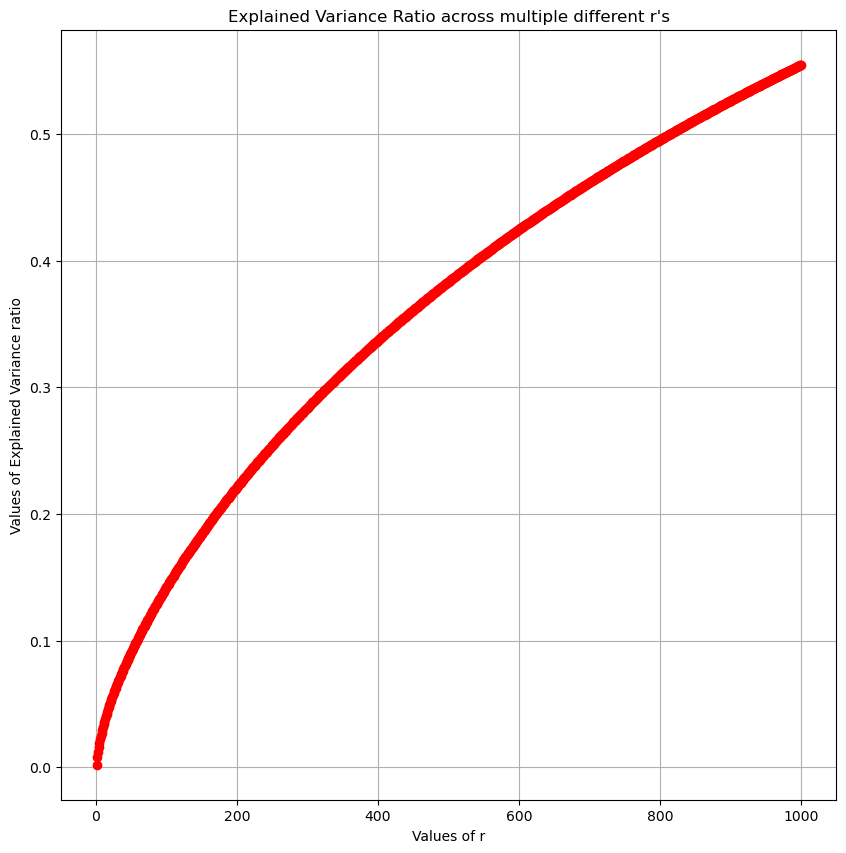

In [ ]:
X_tfidf_sparse = X_tfidf

r = list(np.arange(1, 1001))
explained_variance_ratio = []

for _, item in enumerate(tqdm(r)):
    svd = TruncatedSVD(n_components=item, n_iter=7, random_state=random_seed)
    X_tfidf_dense = svd.fit_transform(X_tfidf_sparse)
    explained_variance_ratio += sum(svd.explained_variance_ratio_),

plt.figure(figsize=(10, 10))
plt.plot(r, explained_variance_ratio, 'o', color = 'red')
plt.xlabel("Values of r")
plt.ylabel("Values of Explained Variance ratio")
plt.title("Explained Variance Ratio across multiple different r's")

# for x_corrdinate, y_corrdinate in zip(k, explained_variance_ratio):
#    plt.text(x_corrdinate, y_corrdinate, f"({x_corrdinate}, {'%.4f' % y_corrdinate})", fontsize=10)

plt.grid()

### <strong>Question 5 </strong><br>
The 5 measure scores for <em>v.s.</em> $r$ for both SVD and NMF are plotted in the two cells below, respectively.<br><br>
(1) A good choice of $r$ for SVD is 300. As shown by the plot named "5 measure scores for SVD", when $r=300$ all the five scores reaches their largest value within the range $1\le r\le 300$ in the graph. Plus, as shown by the plot named "Explained Variance Ratio across multiple different $r$'s" above, the Explained Variance Ratio monotonically increases as $r$ goes up. It means that by selecting $r=300$, we retain much more data information compared with the case when $r=2$. It is a reason although scores for $r=2$ is the second largest, we didn't use $r=2$.<br><br>
(2) A good choice of $r$ for NMF is 2. We oberved two peaks from the plot named "5 measure scores for SVD", one larger at $r=2$ and another smaller at $r=9$. We tend to select a point where all scores are over 0.5 (at $r=2$) rather than lower than 0.3 (at $r=9$). Although more explained variance ratio is achieved at $r=9$, we believe that since $r=2$ is close to $r=9$ and the explained ratioes before $r=10$ are all very low (lower than 0.1), we value measure scores more here than the explained variance ratio.

100%|██████████| 14/14 [01:15<00:00,  5.37s/it]


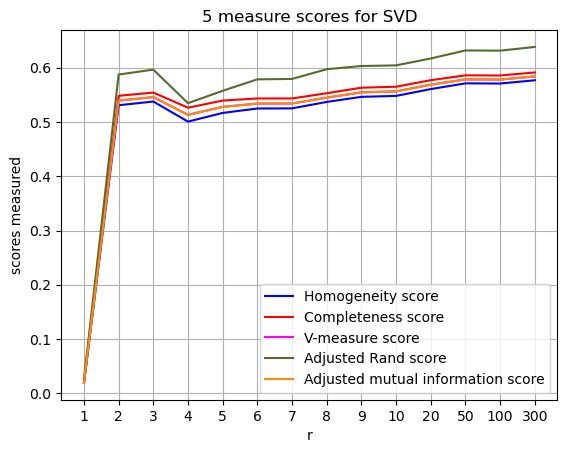

In [ ]:
rs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]
k_ = 2
X_tfidf_sparse = X_tfidf

homo_scores_svd = []
comp_scores_svd = []
v_measures_svd = []
rand_indexes_svd = []
mutual_info_scores_svd = []

kmeans = KMeans(n_clusters=k_,
                random_state=0,
                max_iter=2000,
                n_init=60)

# SVD
for _, r in enumerate(tqdm(rs)):
    svd = TruncatedSVD(n_components=r, n_iter=7, random_state=random_seed)
    X_tfidf_dense = svd.fit_transform(X_tfidf_sparse)
    kmeans.fit(X_tfidf_dense)
    cluster_labels = kmeans.labels_
    homo_scores_svd += homogeneity_score(labels_true=class_binary_labels, labels_pred=cluster_labels),
    comp_scores_svd += completeness_score(labels_true=class_binary_labels, labels_pred=cluster_labels),
    v_measures_svd += v_measure_score(labels_true=class_binary_labels, labels_pred=cluster_labels),
    rand_indexes_svd += adjusted_rand_score(labels_true=class_binary_labels, labels_pred=cluster_labels),
    mutual_info_scores_svd += adjusted_mutual_info_score(labels_true=class_binary_labels, labels_pred=cluster_labels),

plot_5_measure_scores(method="SVD",
                      r=rs,
                      homo_score=homo_scores_svd,
                      comp_score=comp_scores_svd,
                      v_score=v_measures_svd,
                      ar_score=rand_indexes_svd,
                      ami_score=mutual_info_scores_svd)

100%|██████████| 14/14 [14:16<00:00, 61.21s/it] 


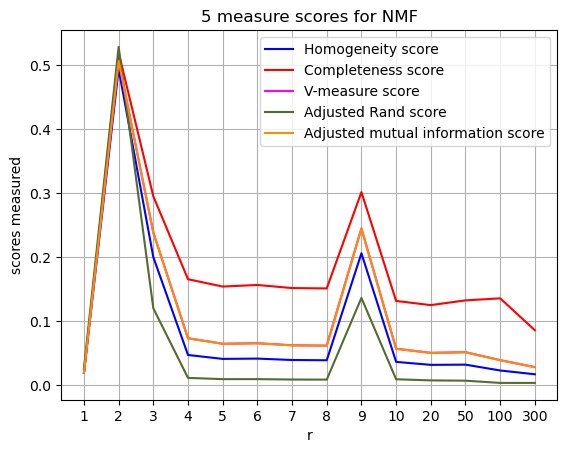

In [ ]:
rs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]
k_ = 2
X_tfidf_sparse = X_tfidf

homo_scores_NMF = []
comp_scores_NMF = []
v_measures_NMF = []
rand_indexes_NMF = []
mutual_info_scores_NMF = []

kmeans = KMeans(n_clusters=k_,
                random_state=0,
                max_iter=2000,
                n_init=60)

# NMF
for _, r in enumerate(tqdm(rs)):
    nmf = NMF(n_components=r, init="random", max_iter=500, random_state=random_seed)
    X_tfidf_dense = nmf.fit_transform(X_tfidf_sparse)
    kmeans.fit(X_tfidf_dense)
    cluster_labels = kmeans.labels_
    homo_scores_NMF += homogeneity_score(labels_true=class_binary_labels, labels_pred=cluster_labels),
    comp_scores_NMF += completeness_score(labels_true=class_binary_labels, labels_pred=cluster_labels),
    v_measures_NMF += v_measure_score(labels_true=class_binary_labels, labels_pred=cluster_labels),
    rand_indexes_NMF += adjusted_rand_score(labels_true=class_binary_labels, labels_pred=cluster_labels),
    mutual_info_scores_NMF += adjusted_mutual_info_score(labels_true=class_binary_labels, labels_pred=cluster_labels),

plot_5_measure_scores(method="NMF",
                      r=rs,
                      homo_score=homo_scores_NMF,
                      comp_score=comp_scores_NMF,
                      v_score=v_measures_NMF,
                      ar_score=rand_indexes_NMF,
                      ami_score=mutual_info_scores_NMF)

In [ ]:
measures_svd = np.array([homo_scores_svd,
                         comp_scores_svd,
                         v_measures_svd,
                         rand_indexes_svd,
                         mutual_info_scores_svd]).reshape(-1, len(rs))
measures_NMF = np.array([homo_scores_NMF,
                         comp_scores_NMF,
                         v_measures_NMF,
                         rand_indexes_NMF,
                         mutual_info_scores_NMF]).reshape(-1, len(rs))

measure_avg_svd = np.mean(measures_svd, axis=0)
measure_avg_NMF = np.mean(measures_NMF, axis=0)

r_argmax_svd = rs[measure_avg_svd.argmax()]
r_argmax_NMF = rs[measure_avg_NMF.argmax()]

r_tradeoff_svd = r_argmax_svd
r_tradeoff_NMF = 2

print(f"a good choice of r for SVD is {r_tradeoff_svd}")
print(f"a good choice of r for NMF is {r_tradeoff_NMF}")

a good choice of r for SVD is 300
a good choice of r for NMF is 2


### <strong>Question 6</strong><br>
For both two dimension reduction method -- SVD and NMF -- K-Mean clustering produces non-monotonic results as $r$ increases. It is because the capacity of the Euclidean Distance on which K-Mean relies to for measuring distances between data points, is weakened when $r$ is large. Specifically, in this high dimensional space(<em>i.e.,</em> when $r$ is large) Euclidean Distances between data points tend to be very close to each other and therefore cannot indicate relashionship between data very well. On the other hand, a small $r$ leads to a greater loss of information, and therefore the measure scores suffer. These are two reasons why a non-monotonic trend is observed in measure scores as $r$ increases.

### <strong>Question 7</strong>
<p>As shown in the plot below, with dimension reduction(both SVD and NMF) the average score for K-Mean can approach(when using SVD, slightly below 0.6 for $r=300$), but CANNOT exceed the performance when no dimension reduction is used as in Question 3(average score was 0.6140958386758719 there). With NMF the average score is even worse.</p>

meausure on average for Question 3 is
0.6140958386758719


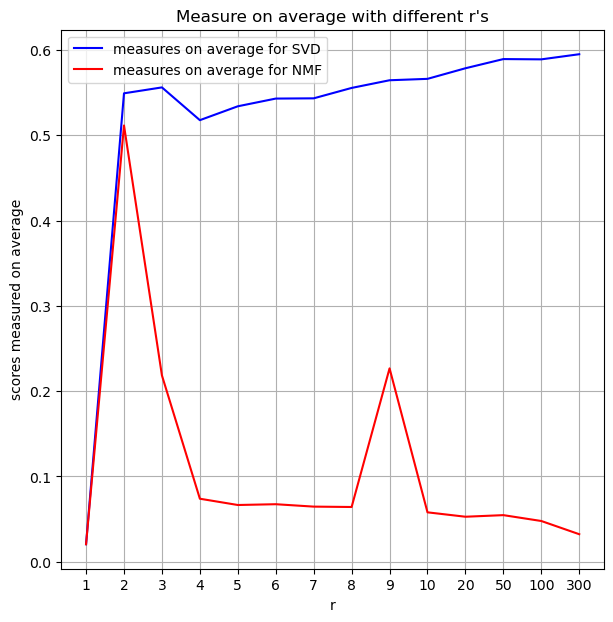

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(measure_avg_svd, "blue", label="measures on average for SVD")
plt.plot(measure_avg_NMF, "red", label="measures on average for NMF")
plt.legend()
plt.xlabel("r");
plt.xticks(np.arange(len(rs)),rs)
plt.ylabel("scores measured on average")
plt.title("Measure on average with different r's")
plt.grid()

print(f"meausure on average for Question 3 is\n{scores_avg_raw}\n")

### <strong>Question 8</strong>

(1) Visualizing the clustering results for SVD with selected $r=300$ for K-Mean clustering.

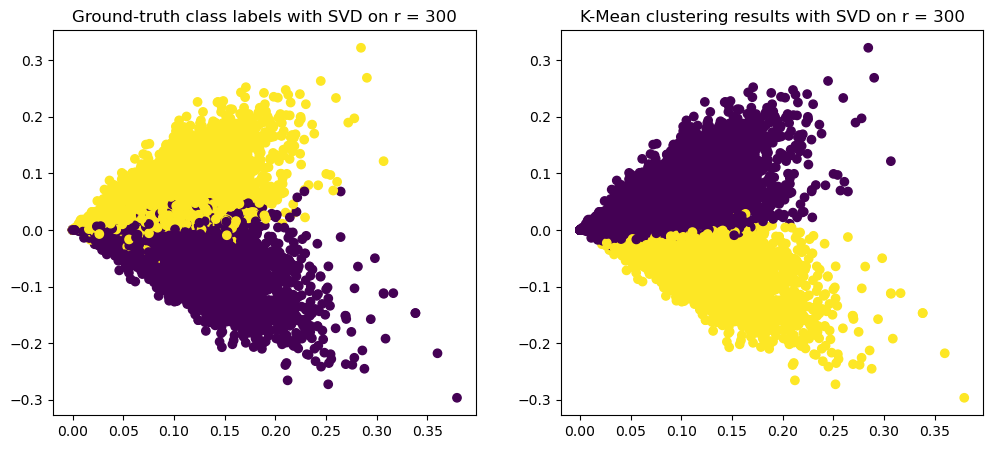

In [ ]:
X_tfidf_sparse = X_tfidf
k_ = 2

kmeans = KMeans(n_clusters=k_,
                random_state=0,
                max_iter=2000,
                n_init=60)

# SVD
svd = TruncatedSVD(n_components=r_tradeoff_svd, n_iter=7, random_state=random_seed)
X_tfidf_dense = svd.fit_transform(X_tfidf_sparse)
kmeans.fit(X_tfidf_dense)
cluster_labels = kmeans.labels_

plt.figure(figsize=(12, 5))

plt.subplot(121)
# projection onto the first two dimensions for view
plt.scatter(X_tfidf_dense[:,0], X_tfidf_dense[:,1],c=class_binary_labels)
plt.title(f"Ground-truth class labels with SVD on r = {r_tradeoff_svd}")

plt.subplot(122)
# projection onto the first two dimensions for view
plt.scatter(X_tfidf_dense[:,0], X_tfidf_dense[:,1],c=cluster_labels)
plt.title(f"K-Mean clustering results with SVD on r = {r_tradeoff_svd}")

pass

(2) Visualizing the clustering results for NMF with selected $r=2$ for K-Mean Clustering.

Text(0.5, 1.0, 'K-Mean clustering results with NMF on r = 2')

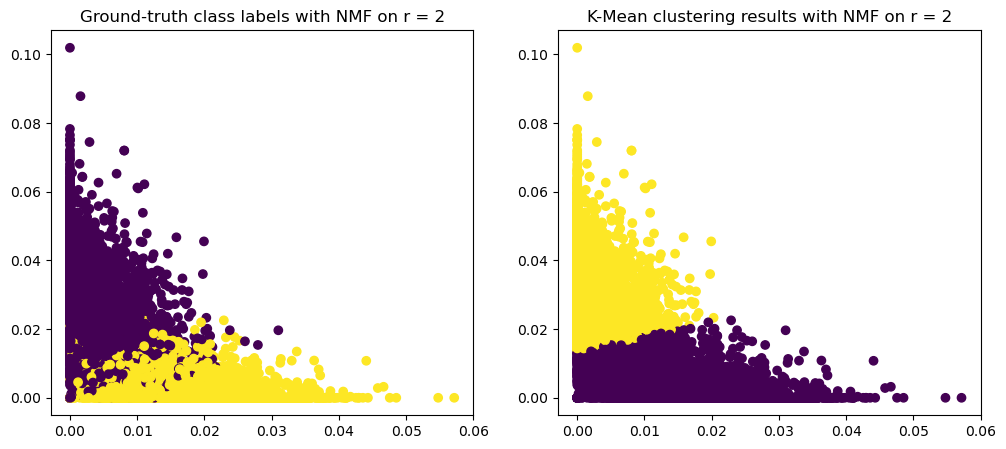

In [ ]:
X_tfidf_sparse = X_tfidf
k_ = 2

kmeans = KMeans(n_clusters=k_,
                random_state=0,
                max_iter=2000,
                n_init=60)

# NMF
nmf = NMF(n_components=r_tradeoff_NMF, init="random", max_iter=500, random_state=random_seed)
X_tfidf_dense = nmf.fit_transform(X_tfidf_sparse)
kmeans.fit(X_tfidf_dense)
cluster_labels = kmeans.labels_

plt.figure(figsize=(12, 5))

plt.subplot(121)
# projection onto the first two dimensions for view
plt.scatter(X_tfidf_dense[:,0], X_tfidf_dense[:,1],c=class_binary_labels)
plt.title(f"Ground-truth class labels with NMF on r = {r_tradeoff_NMF}")

plt.subplot(122)
# projection onto the first two dimensions for view
plt.scatter(X_tfidf_dense[:,0], X_tfidf_dense[:,1],c=cluster_labels)
plt.title(f"K-Mean clustering results with NMF on r = {r_tradeoff_NMF}")

### <strong>Question 9</strong><br>
(1) What do you observe in the visualization?
<p> Compared with the ground-truth, we saw that the two dimension reduction method -- SVD and NMF -- on their respective optimal parameter $r$ can achieve a satisfactory overall performance with K-Mean Clustering, although some data on distribution boundary are more likely to be mis-classified.</p>
(2) How are the data points of the two classes distributed?
<p> Most of data of the same class are "huddled" in clusters with identical density, alothough there are a very small number of "boundary data"(outliers) entering the clutering areas of the opposite class. </p>
(3) Is distribution of the data ideal for K-Means clustering?
<p> Yes.  K-mean is good for spherical and elliptical clusters. Here the data distribution pattern suits well with these. They are well-seperated by K-mean. </p>

### <strong>Question 10</strong>

<p>Here we load data of all the 20 categories. The shape of the TF-IDF matrix before dimension reduction is (18846, 45365) as shown below.</p>

In [ ]:
twenty_news = fetch_20newsgroups(subset='all',
                                 remove=("headers", "footers"),
                                 shuffle=True,
                                 random_state=random_seed)

class_labels = twenty_news.target # 0~19 indicating class index

TFIDF_transformer = TfidfTransformer()
count_vect = CountVectorizer(stop_words='english', min_df=3)
X_counts = count_vect.fit_transform(twenty_news.data)
X_tfidf = TFIDF_transformer.fit_transform(X_counts)
print(f"shape of the TF-IDF matrix obtained:\n{X_tfidf.shape}")

k_ = 20 # all 20 classes
kmeans = KMeans(n_clusters=k_,
                random_state=0,
                max_iter=2000,
                n_init=60)


shape of the TF-IDF matrix obtained:
(18846, 45365)


Do dimension reduction using SVD with $r=2$. <br>
<br> We choose this empirical $r=2$ based on our observation before. Previously when we are given the two well seperated sub-classes, there is a huge leap on measure scores as $r$ goes from 1 to 2. Also, even for greater $r$'s the measure scores won't increase much, never mention for NMF measure scores decreases after $r=2$. Here we do not have sufficient computational resource to perform the "Explained Variance Ratio across multiple different r's" or the "Measure on average with different r's" analysis on data of ALL 20 categories, so we just adopted the empirical $r=2$. </br>
<br> The Contingency Matrix together with the five clustering metrics are shown in the cell below.

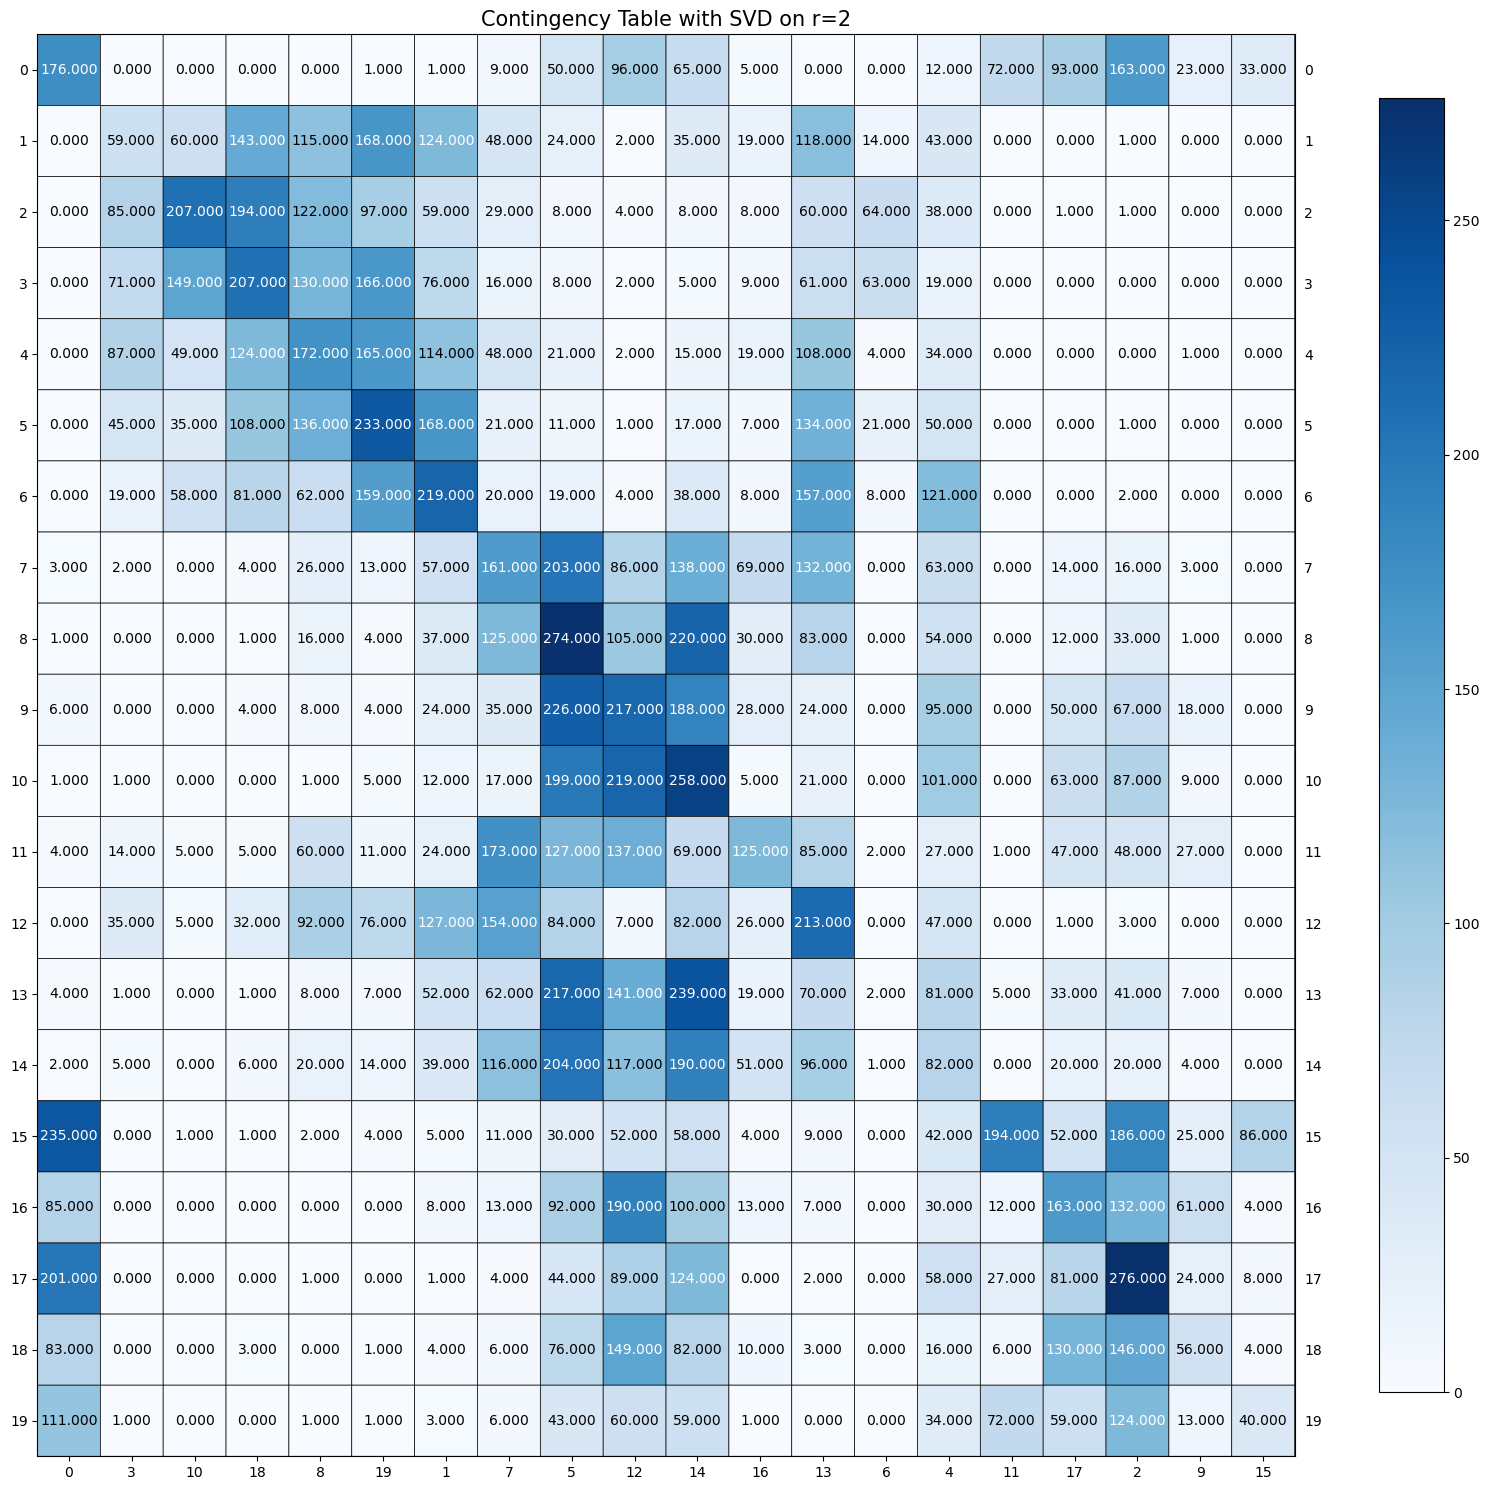

5 Clustering Measures with SVD on r=2:

Homogeneity Score: 0.21085698721866283
Completeness: 0.22321178781679205
V-measurement: 0.2168585615811497
Adjust Rand Index: 0.06549130543923115
Adjusted mutual information score: 0.21425204242309612


In [ ]:
X_tfidf_sparse = X_tfidf

r_ = 2

# SVD -> KMean
svd = TruncatedSVD(n_components=r_, n_iter=7, random_state=random_seed)
X_tfidf_dense = svd.fit_transform(X_tfidf_sparse)
kmeans.fit(X_tfidf_dense)
cluster_labels = kmeans.labels_

"""
One can use scipy.optimize.linear_sum_assignment to identify the
best-matching cluster-class pairs, and permute the columns of
the contingency matrix accordingly.
"""
cm = confusion_matrix(class_labels, cluster_labels)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols],
         xticklabels=cols,
         yticklabels=rows,
         title = f"Contingency Table with SVD on r={r_}",
         size=(15, 15))

homo_score = homogeneity_score(labels_true=class_labels, labels_pred=cluster_labels)
comp_score = completeness_score(labels_true=class_labels, labels_pred=cluster_labels)
v_measure = v_measure_score(labels_true=class_labels, labels_pred=cluster_labels)
rand_index = adjusted_rand_score(labels_true=class_labels, labels_pred=cluster_labels)
mutual_info_score = adjusted_mutual_info_score(labels_true=class_labels, labels_pred=cluster_labels)

print(f"5 Clustering Measures with SVD on r={r_}:\n")
print(f"Homogeneity Score: {homo_score}")
print(f"Completeness: {comp_score}")
print(f"V-measurement: {v_measure}")
print(f"Adjust Rand Index: {rand_index}")
print(f"Adjusted mutual information score: {mutual_info_score}")

Do dimension reduction using NMF with $r=2$. <br>
<br> We choose this empirical $r=2$ based on our observation before. Previously when we are given the two well seperated sub-classes, there is a huge leap on measure scores as $r$ goes from 1 to 2. Also, even for greater $r$'s the measure scores won't increase much, never mention for NMF measure scores decreases after $r=2$. Here we do not have sufficient computational resource to perform the "Explained Variance Ratio across multiple different r's" or the "Measure on average with different r's" analysis on data of ALL 20 categories, so we just adopted the empirical $r=2$. </br>
<br> The Contingency Matrix together with the five clustering metrics are shown in the cell below.

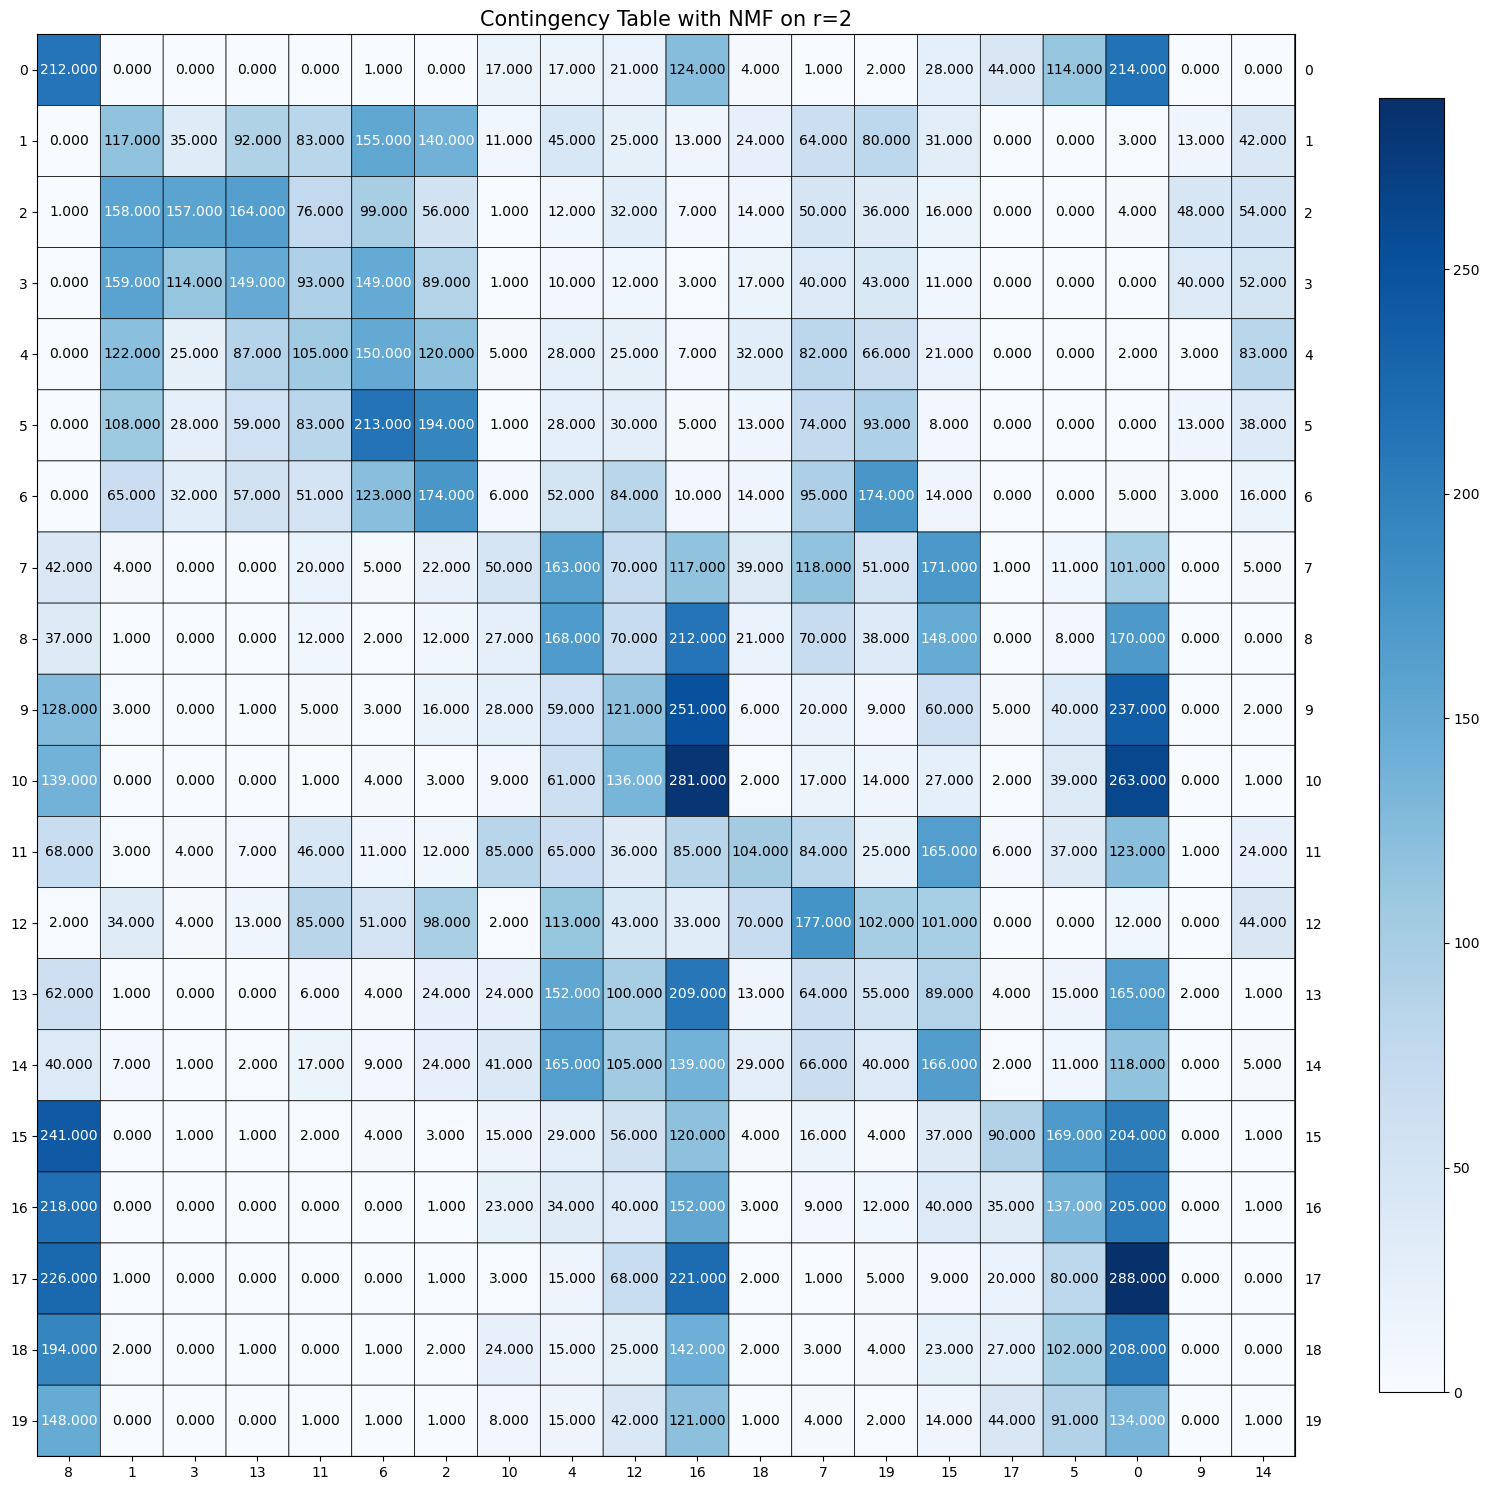

5 Clustering Measures with NMF on r=2:

Homogeneity Score: 0.1913063166653949
Completeness: 0.20439233407661972
V-measurement: 0.19763294372380466
Adjust Rand Index: 0.05681390922880632
Adjusted mutual information score: 0.1949498119249274


In [ ]:
X_tfidf_sparse = X_tfidf

r_ = 2

# NMF -> KMean
nmf = NMF(n_components=r_, init="random", max_iter=500, random_state=random_seed)
X_tfidf_dense = nmf.fit_transform(X_tfidf_sparse)
kmeans.fit(X_tfidf_dense)
cluster_labels = kmeans.labels_

"""
One can use scipy.optimize.linear_sum_assignment to identify the
best-matching cluster-class pairs, and permute the columns of
the contingency matrix accordingly.
"""
cm = confusion_matrix(class_labels, cluster_labels)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols],
         xticklabels=cols,
         yticklabels=rows,
         title = f"Contingency Table with NMF on r={r_}",
         size=(15, 15))

homo_score = homogeneity_score(labels_true=class_labels, labels_pred=cluster_labels)
comp_score = completeness_score(labels_true=class_labels, labels_pred=cluster_labels)
v_measure = v_measure_score(labels_true=class_labels, labels_pred=cluster_labels)
rand_index = adjusted_rand_score(labels_true=class_labels, labels_pred=cluster_labels)
mutual_info_score = adjusted_mutual_info_score(labels_true=class_labels, labels_pred=cluster_labels)

print(f"5 Clustering Measures with NMF on r={r_}:\n")
print(f"Homogeneity Score: {homo_score}")
print(f"Completeness: {comp_score}")
print(f"V-measurement: {v_measure}")
print(f"Adjust Rand Index: {rand_index}")
print(f"Adjusted mutual information score: {mutual_info_score}")

### <strong>Question 11</strong>
<p>The permuted contigency matrices and the five clustering evaluation matrics for different combinations in UMAP are reported in the cell below.</p>

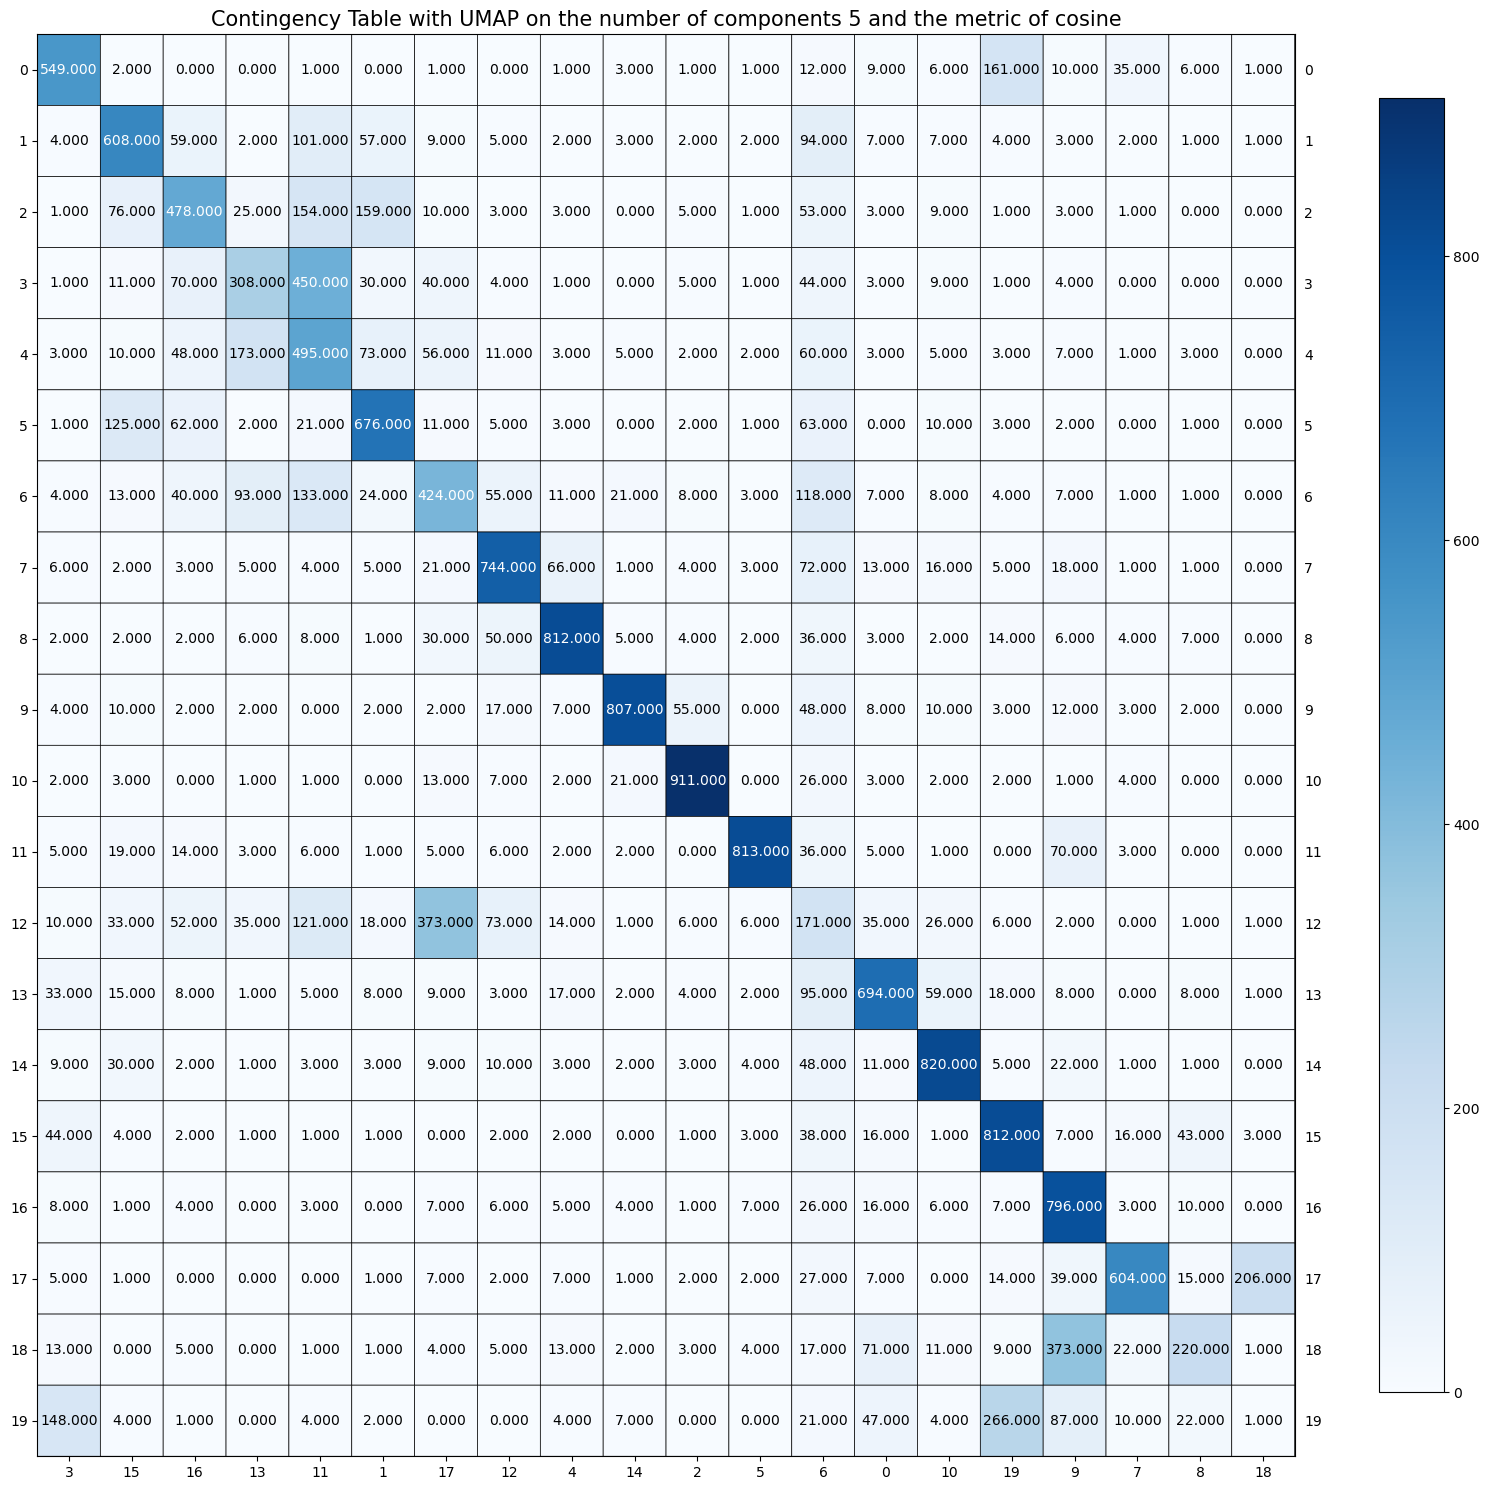

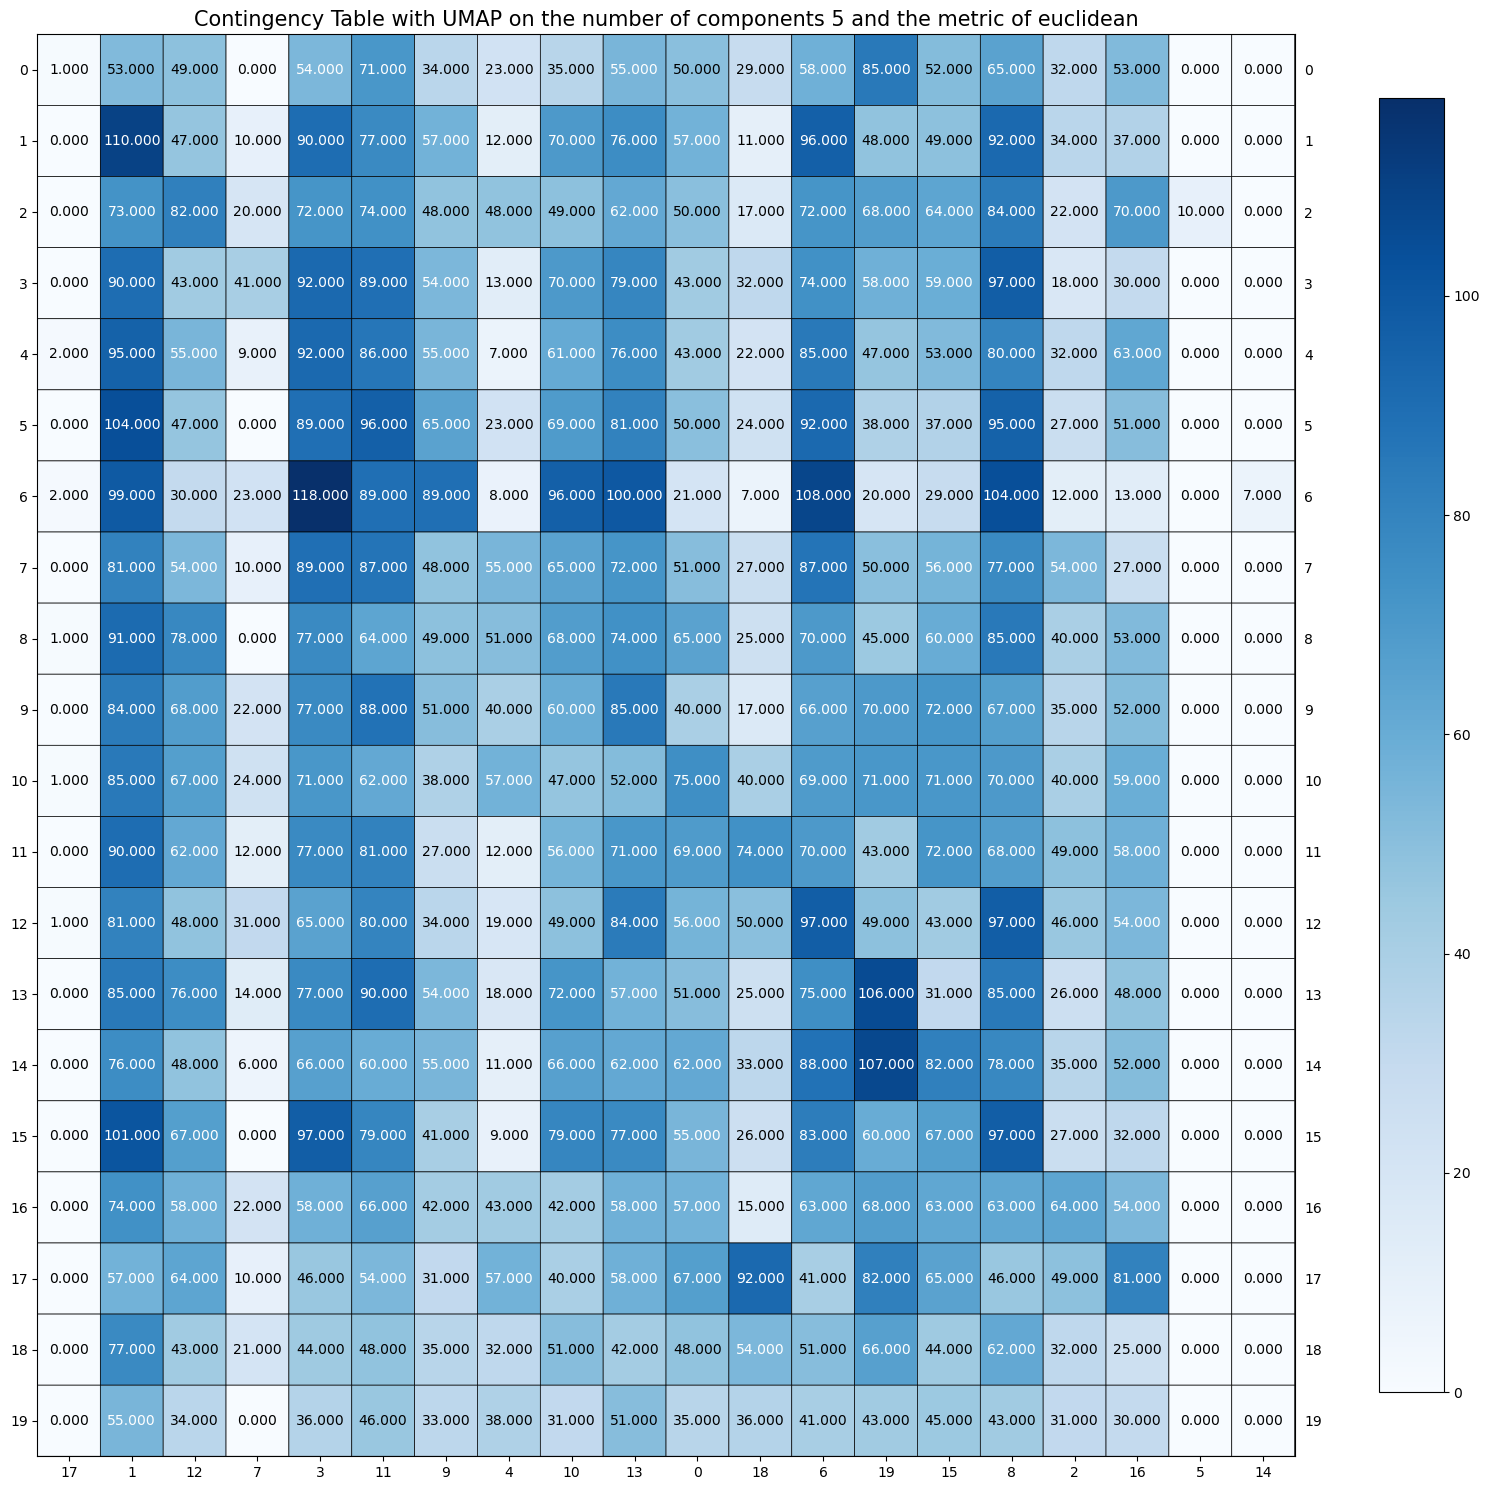

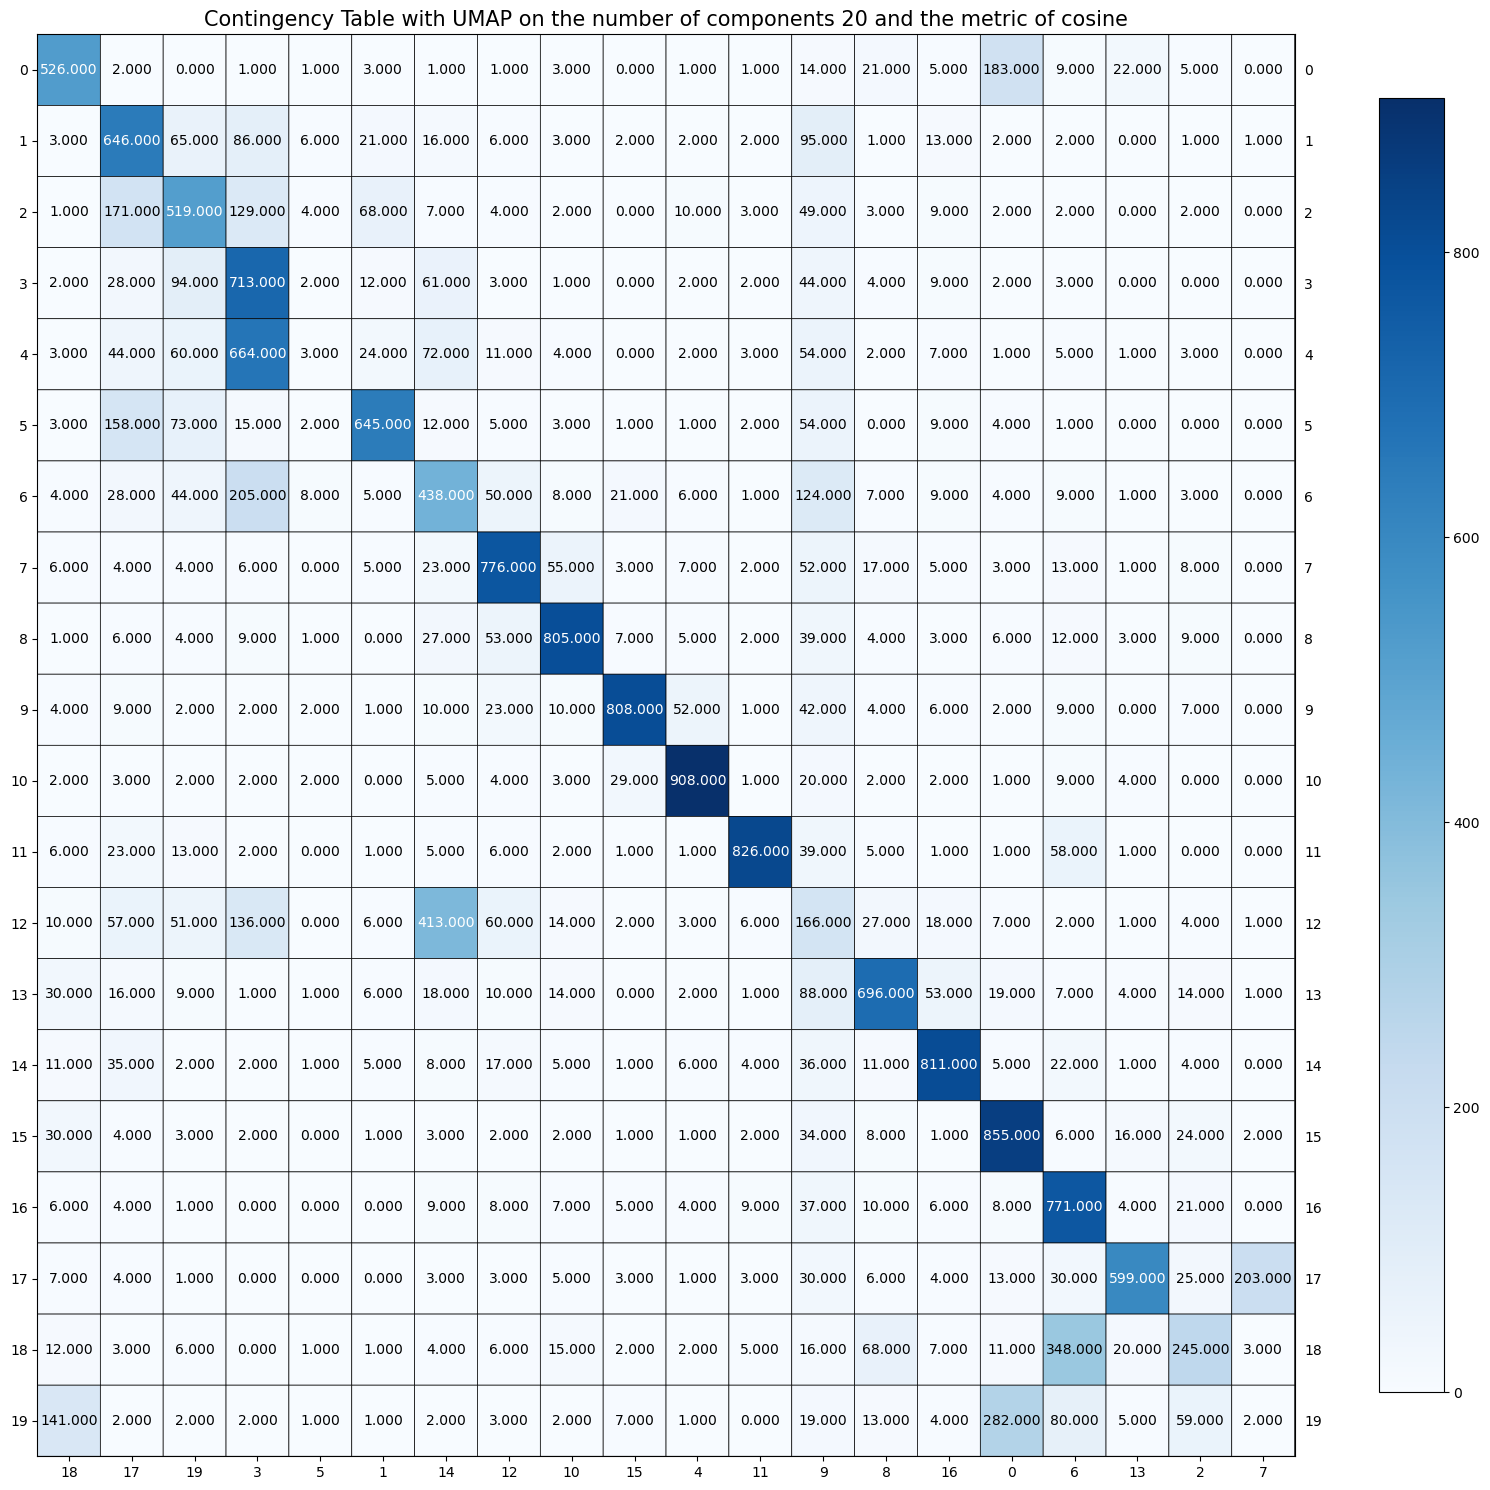

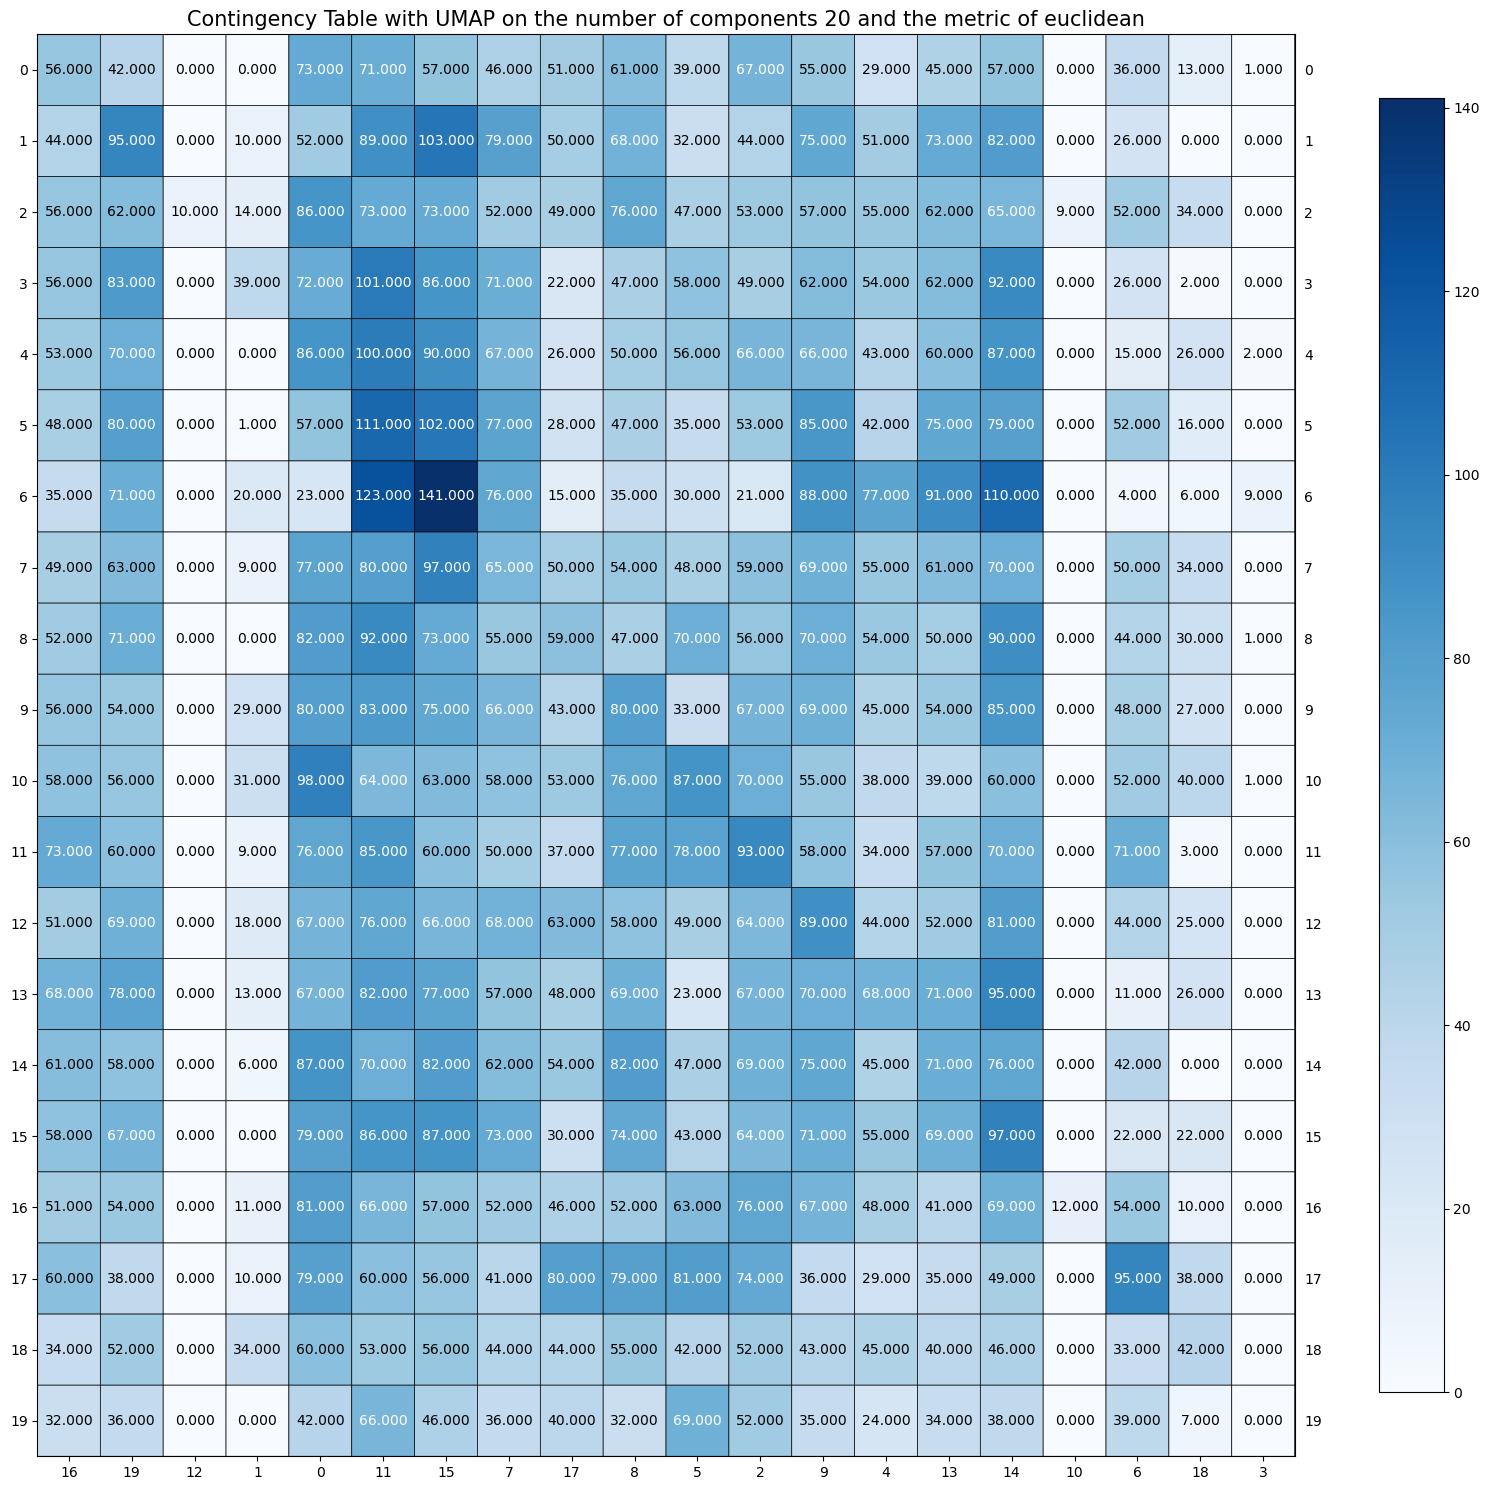

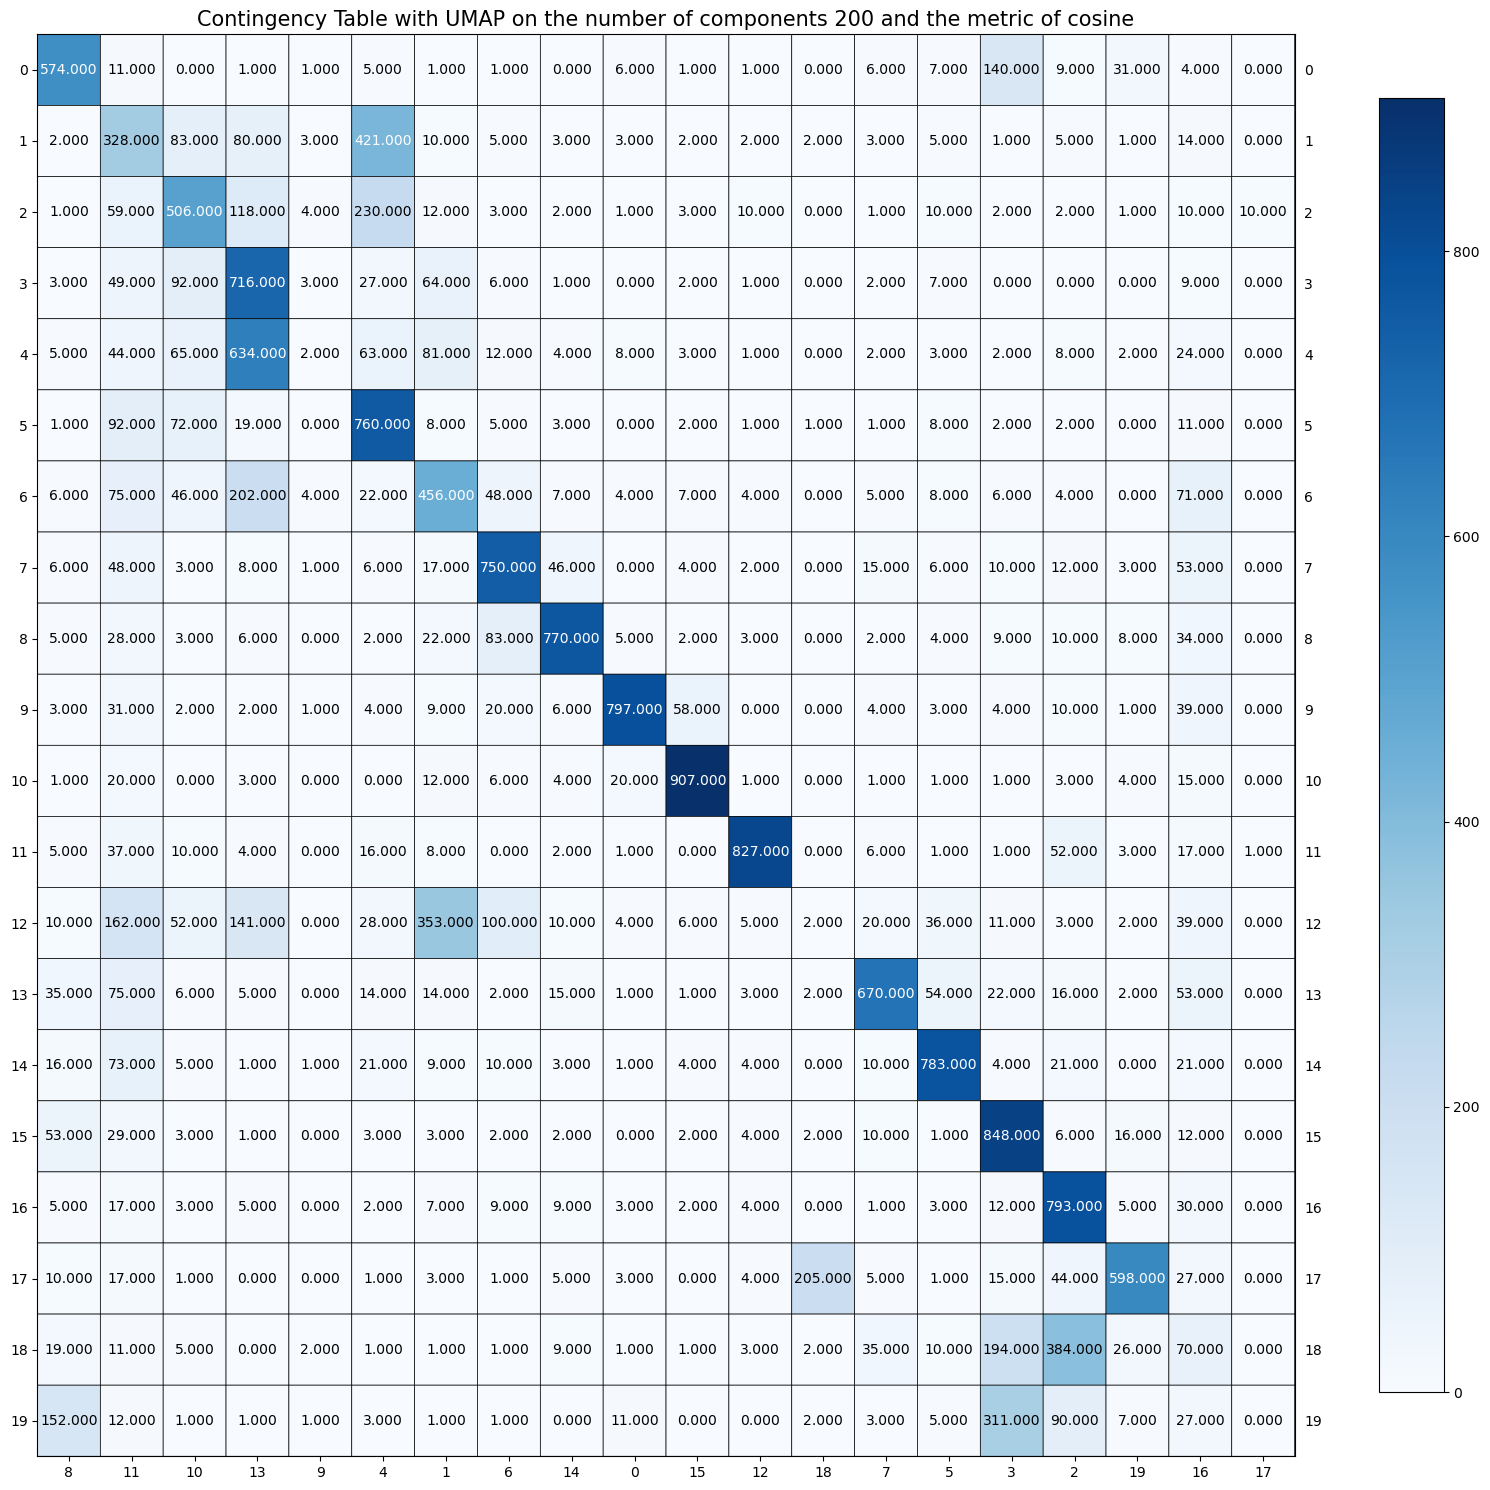

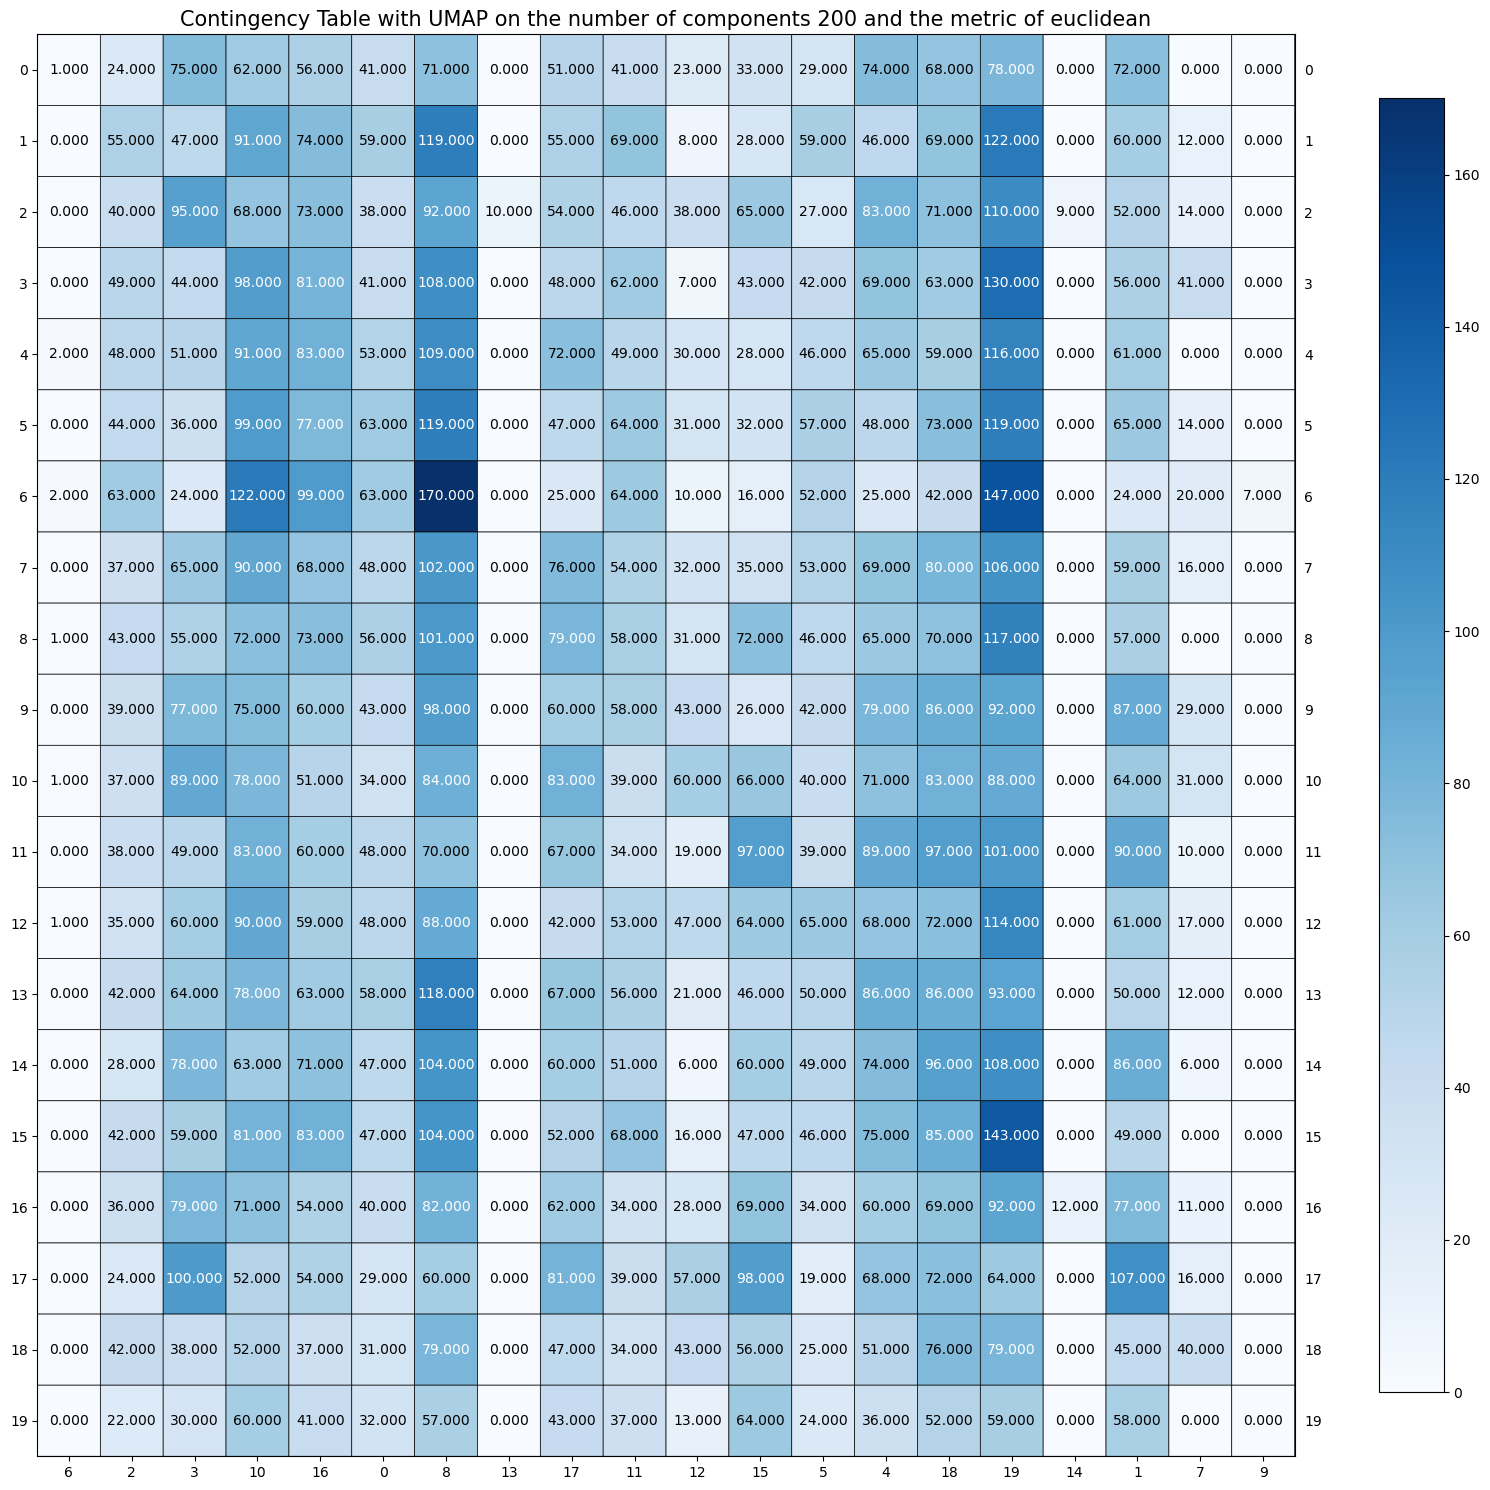


UMAP with the number of components 5 and the metric of cosine:

Homogeneity Score: 0.5750506964167742
Completeness: 0.585811818583922
V-measurement: 0.580381380039064
Adjust Rand Index: 0.453815062803606
Adjusted mutual information score: 0.5790135831654305
Score on average: 0.5548145082017594


UMAP with the number of components 5 and the metric of euclidean:

Homogeneity Score: 0.0156614926130339
Completeness: 0.01687426930856746
V-measurement: 0.016245277720145467
Adjust Rand Index: 0.003016844200436163
Adjusted mutual information score: 0.012970116801069218
Score on average: 0.012953600128650442


UMAP with the number of components 20 and the metric of cosine:

Homogeneity Score: 0.5776231881240823
Completeness: 0.5993666884683594
V-measurement: 0.5882940955291657
Adjust Rand Index: 0.4619022425193774
Adjusted mutual information score: 0.5869290885507984
Score on average: 0.5628230606383566


UMAP with the number of components 20 and the metric of euclidean:

Homogeneity Score: 0.

In [ ]:
X_tfidf_sparse = X_tfidf

k_ = 20 # all 20 classes
kmeans = KMeans(n_clusters=k_,
                random_state=0,
                max_iter=2000,
                n_init=60)

n_components_ls = [5, 20, 200]
metrics_ls = ["cosine", "euclidean"]

homo_score_dict = {}
comp_score_dict = {}
v_measure_dict = {}
rand_index_dict = {}
mutual_info_score_dict = {}

for i in n_components_ls:
    for j in metrics_ls:
        X_tfidf_dense = umap.UMAP(n_components=i, metric=j).fit_transform(X_tfidf_sparse)
        preds = kmeans.fit(X_tfidf_dense)

        cm = confusion_matrix(class_labels, preds.labels_)
        rows, cols = linear_sum_assignment(cm, maximize=True)
        plot_mat(cm[rows[:, np.newaxis], cols],
                 xticklabels=cols,
                 yticklabels=rows,
                 title = f"Contingency Table with UMAP on the number of components {i} and the metric of {j}",
                 size=(15, 15))

        homo_score_dict.update({f"{str(i)}+{j}": homogeneity_score(class_labels, preds.labels_)})
        comp_score_dict.update({f"{str(i)}+{j}": completeness_score(class_labels, preds.labels_)})
        v_measure_dict.update({f"{str(i)}+{j}": v_measure_score(class_labels, preds.labels_)})
        rand_index_dict.update({f"{str(i)}+{j}": adjusted_rand_score(class_labels, preds.labels_)})
        mutual_info_score_dict.update({f"{str(i)}+{j}": adjusted_mutual_info_score(class_labels, preds.labels_)})

key_ls = []
score_avg_ls = []

for i in n_components_ls:
    for j in metrics_ls:
        key = str(i) + "+" + j
        key_ls += key,
        print(f"\nUMAP with the number of components {i} and the metric of {j}:\n")
        print(f"Homogeneity Score: {homo_score_dict[key]}")
        print(f"Completeness: {comp_score_dict[key]}")
        print(f"V-measurement: {v_measure_dict[key]}")
        print(f"Adjust Rand Index: {rand_index_dict[key]}")
        print(f"Adjusted mutual information score: {mutual_info_score_dict[key]}")
        score_avg = np.mean(np.array([homo_score_dict[key],
                                      comp_score_dict[key],
                                      v_measure_dict[key],
                                      rand_index_dict[key],
                                      mutual_info_score_dict[key]]))
        score_avg_ls += score_avg,
        print(f"Score on average: {score_avg}\n")

idx = score_avg_ls.index(max(score_avg_ls))
comb_opt = key_ls[idx]
print(f"\nthe best combination is {comb_opt}")


### <strong>Question 12</strong>
<p>Analyze the contingency matrices.</p>
<p>(1) Which setting works best and why?</p>
<p>As shown by the 6 experiments above, the best combination is the metric "cosine" and n_components "20" as it reaches the highest score on average. The average score is the average across the 5 measure scores -- homogeneity, completeness, v-measure, adjusted rand index, and adjusted mutual information score.</p>
<p>(2) What about for each metric choice?</p>
<p> As shown by the 6 experiments above, metrics "cosine" performs SIGNFICATELY BETTER than metrics "euclidean" does. There are distinct diagonal elements in contingency tables with "cosine", whereas contingency tables with "euclidean" appears very messy. Measure scores also tells the significant difference in performance of "cosine" and "euclidean". </p>

### <strong>Question 13</strong><br>
For this 20-classes KMean, we compare and contrast the clustering results across 4 dimension reduction methods -- sparse TF-IDF representation, PCA-reduced, NMF-reduced, and UMAP-reduced. Average Measure Scores for different combinations (where n_combination varies) are calculated in the cell below. We saw that performance of PCA-reduced (SVD) and NMF combined with $2\le r \le 200$ are both worse than that for sparse TF-IDF representation. With UMAP the performance achieve great leap, exceeeding that for sparse TF-IDF representation and reaching over 0.54 in Average Measure Score. And the experiment result tells us that, with $r\in \left \{ 2, 5, 20, 200 \right \}$ for 20-class KMean, the best combination is UMAP with $r=5$, which achieves the Average Measure Score of 0.5574687339635719. Here inspired by the previous cell, we use the metric "cosine" for UMAP.

In [ ]:
X_tfidf_sparse = X_tfidf # sparse TF-IDF representation

DimReduceMethod_ls = ["None", "SVD", "NMF", "UMAP"]
r_ls = [2, 5, 20, 200] # different num_components

k_ = 20
kmeans = KMeans(n_clusters=k_,
                random_state=0,
                max_iter=2000,
                n_init=60)

ScoreAvg_dict = {}
preds_dict = {}

for DimReduceMethod in DimReduceMethod_ls:
    if DimReduceMethod == "None": # sparse TF-IDF representation
        X_dense = get_dense_representation(X_sparse=X_tfidf_sparse, DimReduceMethod=DimReduceMethod)
        preds = kmeans.fit(X_dense)
        score_avg = get_ScoreAvg(class_labels, preds.labels_)
        ScoreAvg_dict.update({f"DimReductionMethod = {DimReduceMethod}": score_avg})
        preds_dict.update({f"DimReductionMethod = {DimReduceMethod}": preds.labels_})
        print(f"Average Measure Score for DimReductionMethod {DimReduceMethod} is: {score_avg}\n")
    else:
        for r in r_ls:
            X_dense = get_dense_representation(X_sparse=X_tfidf_sparse, DimReduceMethod=DimReduceMethod, r=r)
            preds = kmeans.fit(X_dense)
            score_avg = get_ScoreAvg(class_labels, preds.labels_)
            ScoreAvg_dict.update({f"DimReductionMethod = {DimReduceMethod} with r = {r}": score_avg})
            preds_dict.update({f"DimReductionMethod = {DimReduceMethod} with r = {r}": preds.labels_})
            print(f"Average Measure Score for DimReductionMethod {DimReduceMethod} with r = {r} is: {score_avg}\n")


TheKey = max(ScoreAvg_dict, key=ScoreAvg_dict.get)
print(f"\nTHE OPTIMAL RESULT:\n {TheKey} is \n{ScoreAvg_dict[TheKey]}")

Average Measure Score for DimReductionMethod None is: 0.32994359652349486

Average Measure Score for DimReductionMethod SVD with r = 2 is: 0.1861341368957864

Average Measure Score for DimReductionMethod SVD with r = 5 is: 0.29515695931375646

Average Measure Score for DimReductionMethod SVD with r = 20 is: 0.29921784931731377

Average Measure Score for DimReductionMethod SVD with r = 200 is: 0.3032005953009852

Average Measure Score for DimReductionMethod NMF with r = 2 is: 0.16901906312391063

Average Measure Score for DimReductionMethod NMF with r = 5 is: 0.27182123100159633

Average Measure Score for DimReductionMethod NMF with r = 20 is: 0.28856625670327185

Average Measure Score for DimReductionMethod NMF with r = 200 is: 0.072448078239164

Average Measure Score for DimReductionMethod UMAP with r = 2 is: 0.5412941226383613

Average Measure Score for DimReductionMethod UMAP with r = 5 is: 0.5574687339635719

Average Measure Score for DimReductionMethod UMAP with r = 20 is: 0.55423

We plot the Contingency Table and display the 5 measure scores for the best choice of "UMAP with $r=5$" for 20-class KMean here.

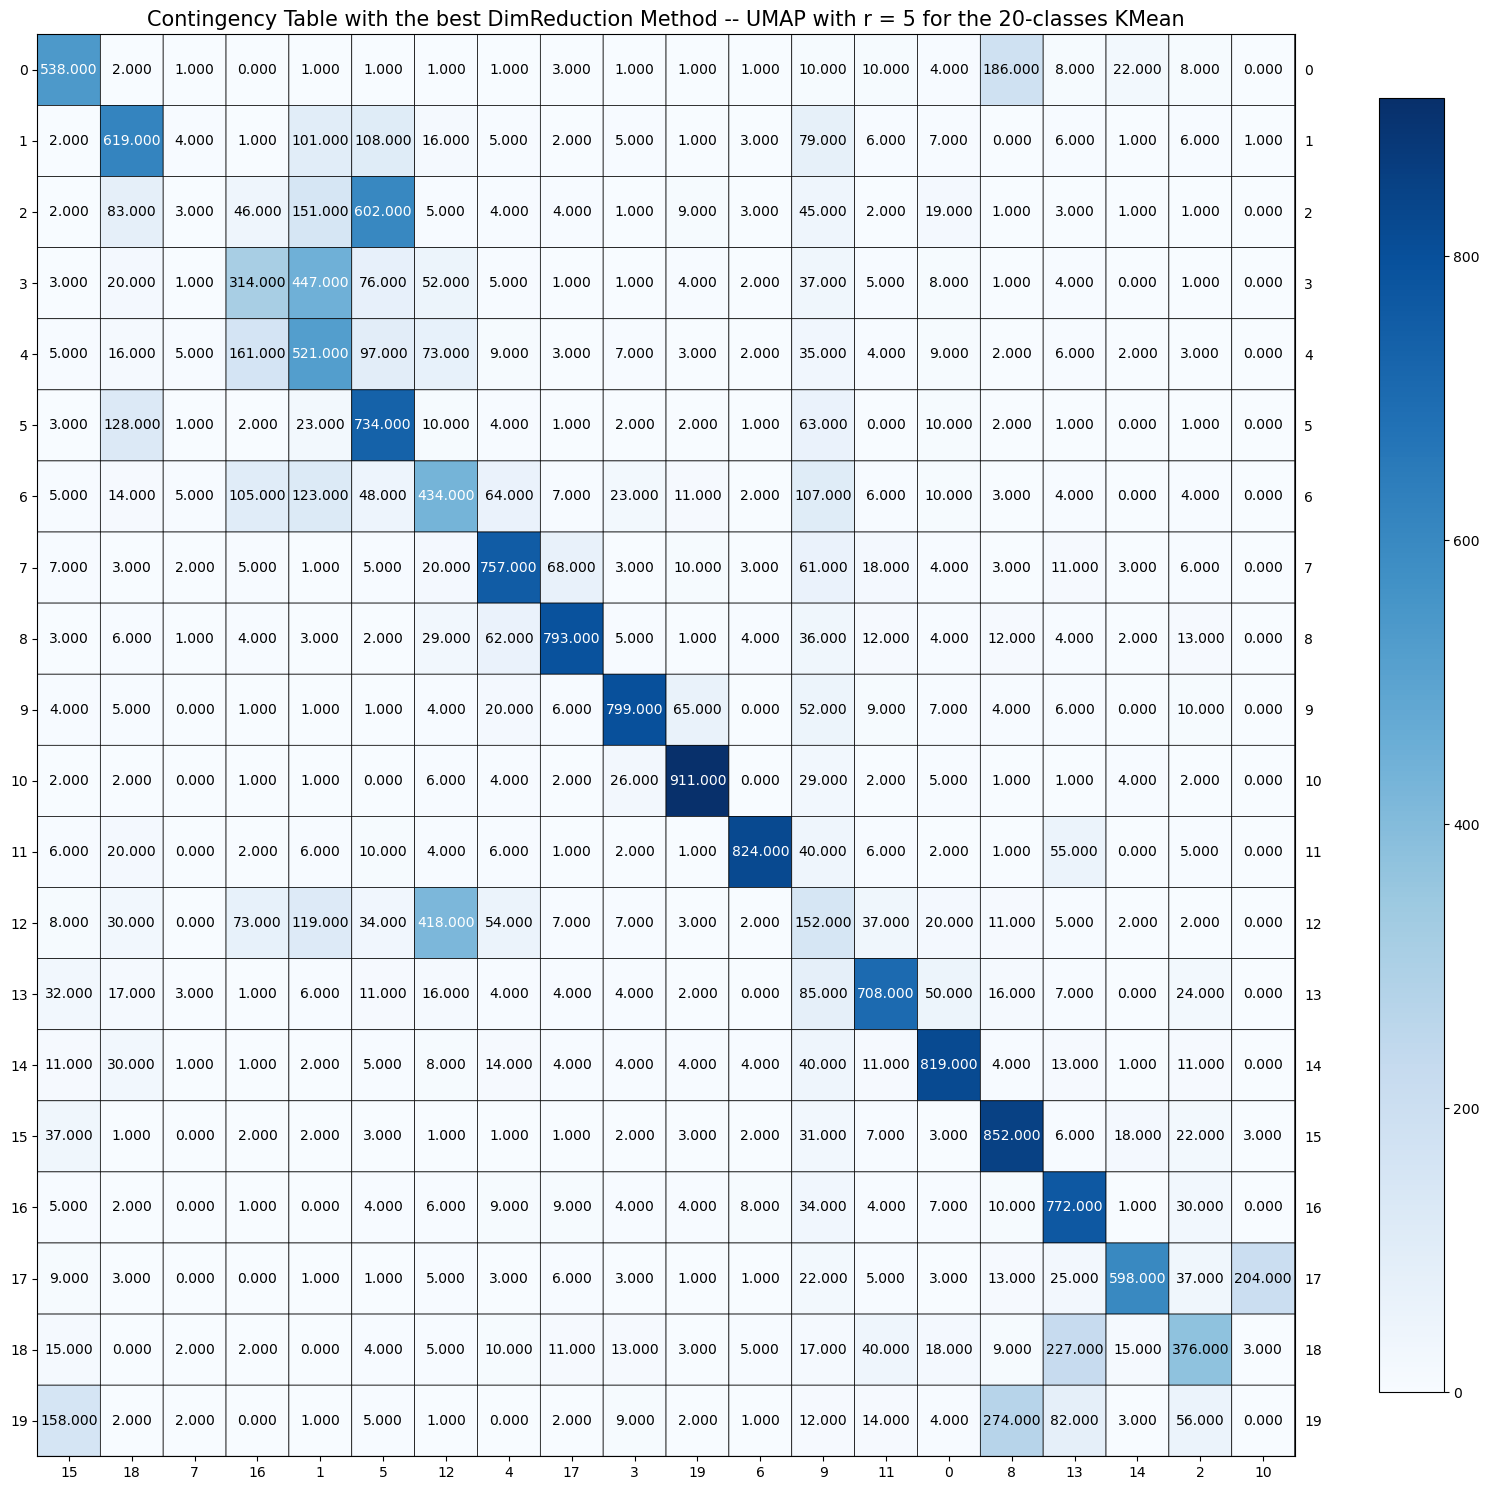

Metrics of the best DimReduction Method -- UMAP with r = 5 for the 20-classes KMean:


Homogeneity Score: 0.5736538625597274
Completeness: 0.5931658325147332
V-measurement: 0.5832467045198764
Adjust Rand Index: 0.4554103746402157
Adjusted mutual information score: 0.5818668955833067

Score on Average: 0.5574687339635719


In [ ]:
preds_opt = preds_dict[TheKey]

cm = confusion_matrix(class_labels, preds_opt)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols],
         xticklabels=cols,
         yticklabels=rows,
         title = f"Contingency Table with the best DimReduction Method -- UMAP with r = 5 for the 20-classes KMean",
         size=(15, 15))

homo_score = homogeneity_score(class_labels, preds_opt)
comp_score = completeness_score(class_labels, preds_opt)
v_measure = v_measure_score(class_labels, preds_opt)
rand_index = adjusted_rand_score(class_labels, preds_opt)
mutual_info_score = adjusted_mutual_info_score(class_labels, preds_opt)

ScoreAvg = np.mean(np.array([homo_score,
                             comp_score,
                             v_measure,
                             rand_index,
                             mutual_info_score]))

print(f"Metrics of the best DimReduction Method -- UMAP with r = 5 for the 20-classes KMean:\n\n")
print(f"Homogeneity Score: {homo_score}")
print(f"Completeness: {comp_score}")
print(f"V-measurement: {v_measure}")
print(f"Adjust Rand Index: {rand_index}")
print(f"Adjusted mutual information score: {mutual_info_score}")
print(f"\nScore on Average: {ScoreAvg}")

### <strong>Question 14</strong>
<p>The five clustering evaluation metrics, together with respective Contingency Tables, for "single" and "ward" are reported in the cell below.We observe that, "ward" is SIGNIFICANTLY better than "single" in terms of both evaluation metrics and Contingency Table.</p>

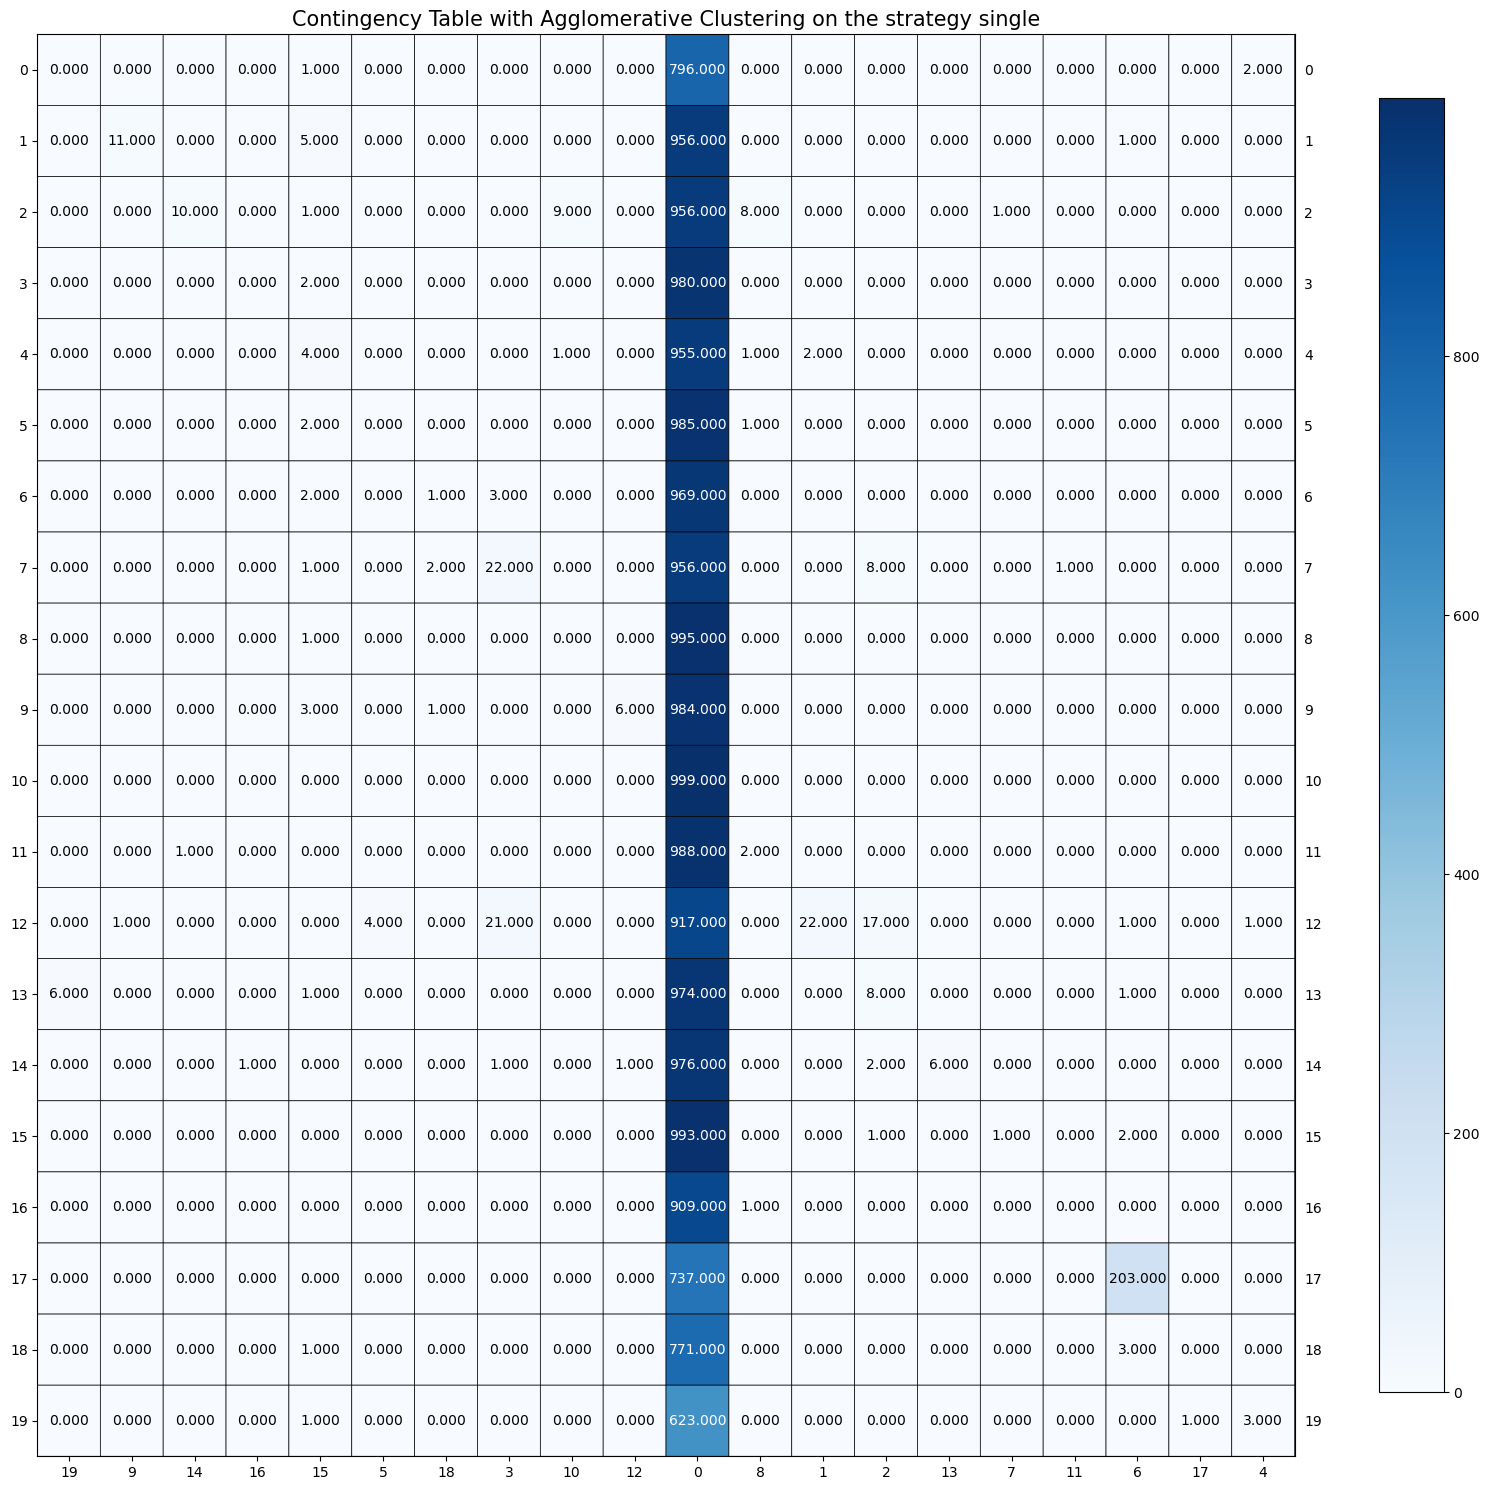

Metrics of agglomerative clustering on the strategy single:

Homogeneity score:  0.018674020613159627
Completeness score:  0.3681301284846457
V-measure score:  0.035544963122456745
Adjusted Rand score:  0.0004726956075780335
Adjusted mutual information score:  0.030478007720693295


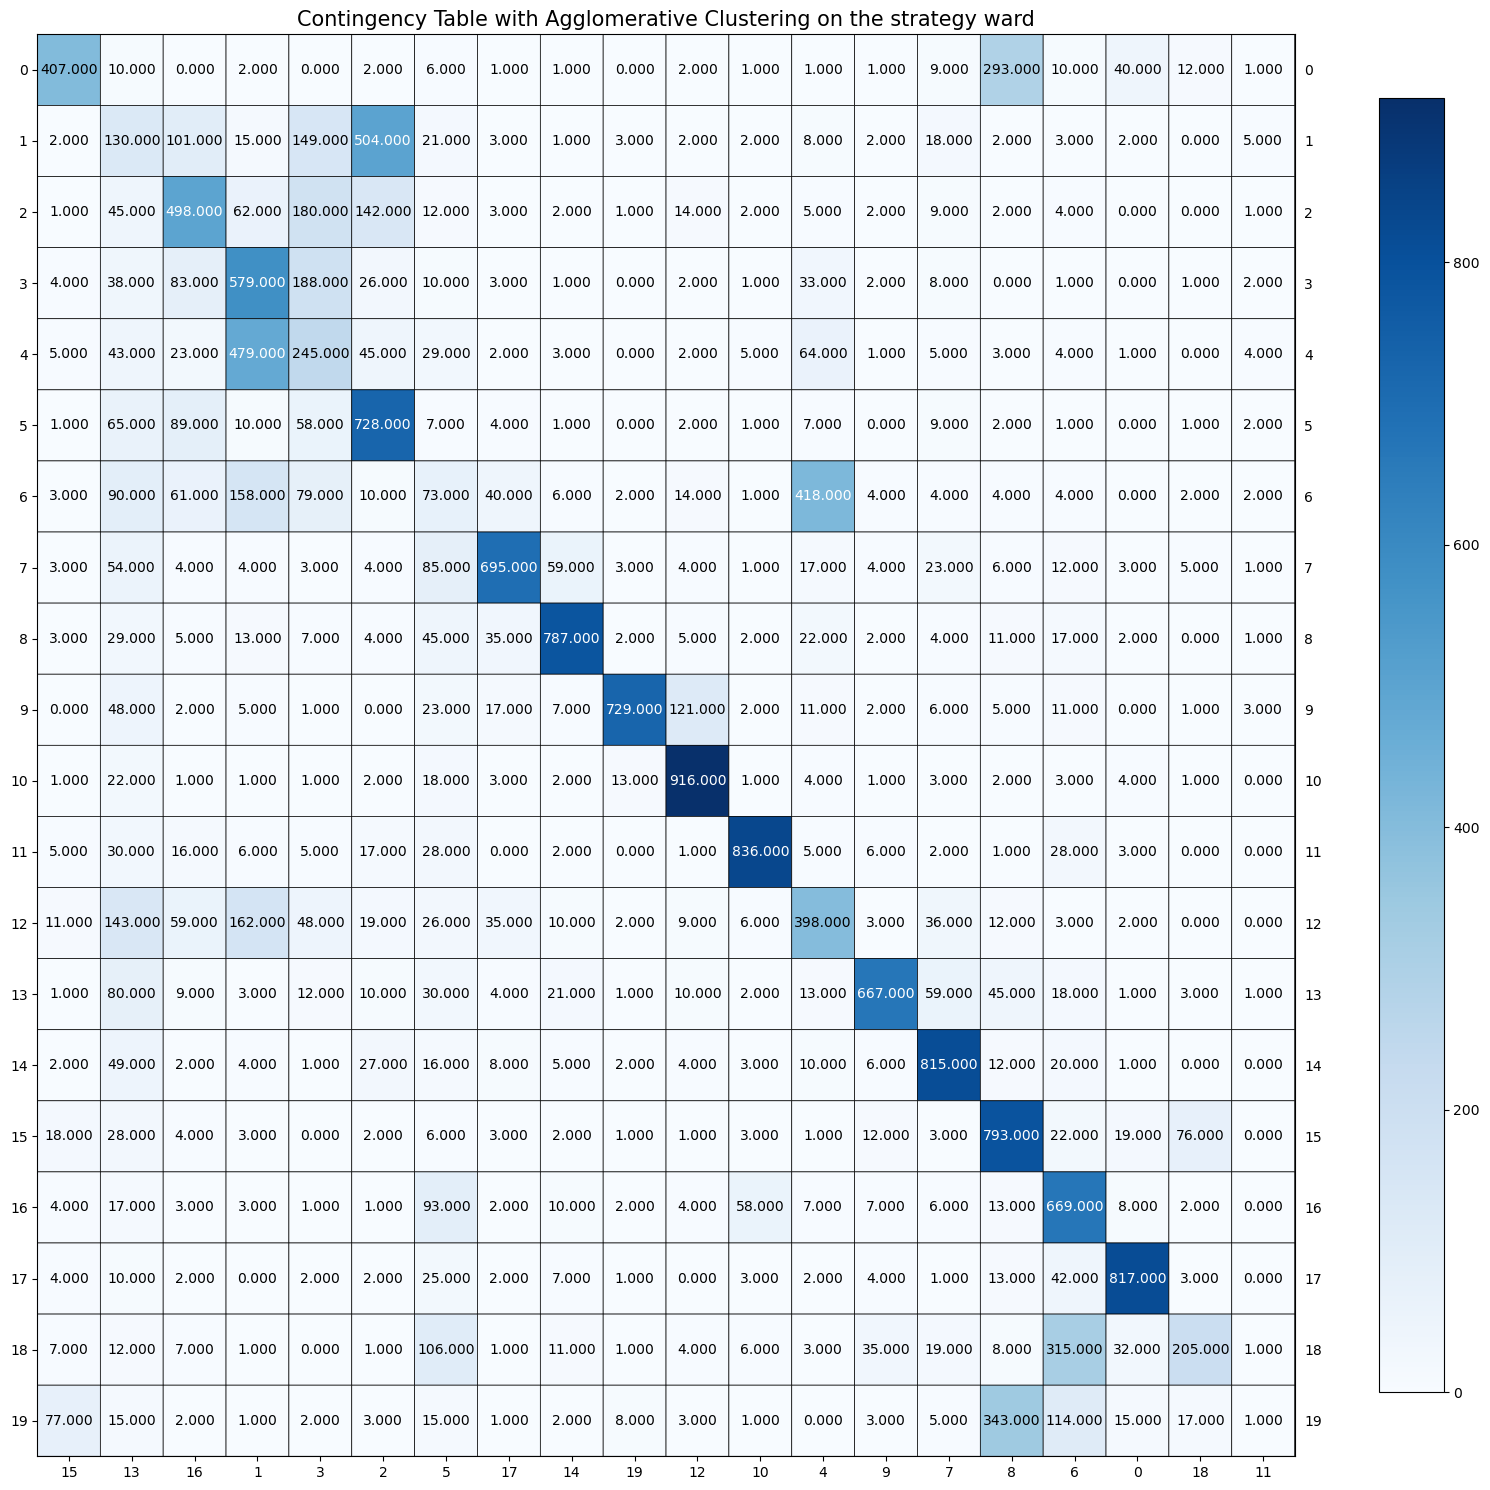

Metrics of agglomerative clustering on the strategy ward:

Homogeneity score:  0.5560747563251014
Completeness score:  0.5737038017371802
V-measure score:  0.5647517373686958
Adjusted Rand score:  0.4334288822786205
Adjusted mutual information score:  0.5633123765053577


In [ ]:
# Agglomerative Clustering
X_tfidf_sparse = X_tfidf

k_ = 20 # all 20 classes

X_tfidf_dense_opt = umap.UMAP(n_components=200, metric="cosine").fit_transform(X_tfidf_sparse)

for strategy in ["single", "ward"]:
    agg = AgglomerativeClustering(n_clusters=k_, linkage=strategy)
    preds = agg.fit_predict(X_tfidf_dense_opt)
    cm = confusion_matrix(class_labels, preds)
    rows, cols = linear_sum_assignment(cm, maximize=True)
    plot_mat(cm[rows[:, np.newaxis], cols],
             xticklabels=cols,
             yticklabels=rows,
             title = f"Contingency Table with Agglomerative Clustering on the strategy {strategy}",
             size=(15, 15))
    print(f"Metrics of agglomerative clustering on the strategy {strategy}:\n")
    print("Homogeneity score: ", homogeneity_score(class_labels,preds))
    print("Completeness score: ",completeness_score(class_labels,preds))
    print("V-measure score: ",v_measure_score(class_labels,preds))
    print("Adjusted Rand score: ",adjusted_rand_score(class_labels,preds))
    print("Adjusted mutual information score: ",adjusted_mutual_info_score(class_labels,preds))


### <strong>Question 15</strong><br>
We vary three parameters -- "min_cluster_size", "min_sample", and "cluster_selection_epsilon" -- and try to find the best combination for HDBSCAN. Five clustering evaluation metrics for each combination is reported below. As shown by the result, the best combination is "min_cluster_size200 + min_samples2 + cluster_selection_epsilon0.01", and it gives the highest score on average of 0.4656340299292193.

In [ ]:
# HDBSCAN

X_tfidf_sparse = X_tfidf
X_tfidf_dense_opt = umap.UMAP(n_components=200, metric="cosine").fit_transform(X_tfidf_sparse)

k_ = 20 # all 20 classes

min_cluster_size_ls = [20, 100, 200]
min_samples_ls = [2, 4, 5, 10, 20]
cluster_selection_epsilon_ls = [0.01, 0.02, 0.04, 0.05, 0.1, 0.2, 0.5]

homo_score_dict = {}
comp_score_dict = {}
v_measure_dict = {}
rand_index_dict = {}
mutual_info_score_dict = {}
hdbscan_dict = {}
hdbscan_preds_dict = {}

count = 0
for i in min_cluster_size_ls:
    for j in min_samples_ls:
        for k in cluster_selection_epsilon_ls:
            hdbscan = HDBSCAN(min_cluster_size=i,
                              min_samples=j,
                              cluster_selection_epsilon=k)
            preds = hdbscan.fit_predict(X_tfidf_dense_opt)

            hdbscan_dict.update({f"min_cluster_size{str(i)} + min_samples{str(j)} + cluster_selection_epsilon{str(k)}": hdbscan})
            hdbscan_preds_dict.update({f"min_cluster_size{str(i)} + min_samples{str(j)} + cluster_selection_epsilon{str(k)}": preds})
            homo_score_dict.update({f"min_cluster_size{str(i)} + min_samples{str(j)} + cluster_selection_epsilon{str(k)}": homogeneity_score(class_labels, preds)})
            comp_score_dict.update({f"min_cluster_size{str(i)} + min_samples{str(j)} + cluster_selection_epsilon{str(k)}": completeness_score(class_labels, preds)})
            v_measure_dict.update({f"min_cluster_size{str(i)} + min_samples{str(j)} + cluster_selection_epsilon{str(k)}": v_measure_score(class_labels, preds)})
            rand_index_dict.update({f"min_cluster_size{str(i)} + min_samples{str(j)} + cluster_selection_epsilon{str(k)}": adjusted_rand_score(class_labels, preds)})
            mutual_info_score_dict.update({f"min_cluster_size{str(i)} + min_samples{str(j)} + cluster_selection_epsilon{str(k)}": adjusted_mutual_info_score(class_labels, preds)})

            count += 1
            total_num = len(min_cluster_size_ls) * len(min_samples_ls) * len(cluster_selection_epsilon_ls)
            progress = count / total_num
            bar = int(progress * total_num)
            print('[' + '#' *  bar + ' ' * (total_num - bar) + ']', end='\r')


key_ls = []
score_avg_ls = []

for i in min_cluster_size_ls:
    for j in min_samples_ls:
        for k in cluster_selection_epsilon_ls:
            key = f"min_cluster_size{str(i)} + min_samples{str(j)} + cluster_selection_epsilon{str(k)}"
            key_ls += key,
            print(f"\nMetrics of HDBSCAN on the min_cluster_size {i}, min_samples {j}, and cluster_selection_epsilon {k}:\n")
            print(f"Homogeneity score: {homo_score_dict[key]}")
            print(f"Completeness score: {comp_score_dict[key]}")
            print(f"V-measure score: {v_measure_dict[key]}")
            print(f"Adjusted Rand score: {rand_index_dict[key]}")
            print(f"Adjusted mutual information score: {mutual_info_score_dict[key]}")
            score_avg = np.mean(np.array([homo_score_dict[key],
                                          comp_score_dict[key],
                                          v_measure_dict[key],
                                          rand_index_dict[key],
                                          mutual_info_score_dict[key]]))
            score_avg_ls += score_avg,
            print(f"Score on average: {score_avg}\n")

idx = score_avg_ls.index(max(score_avg_ls))
comb_opt = key_ls[idx]
print(f"\nthe best combination is {comb_opt}")


[#########################################################################################################]
Metrics of HDBSCAN on the min_cluster_size 20, min_samples 2, and cluster_selection_epsilon 0.01:

Homogeneity score: 0.4927325162811424
Completeness score: 0.3627465352975924
V-measure score: 0.4178641494016729
Adjusted Rand score: 0.020969358080806338
Adjusted mutual information score: 0.3922468245066852
Score on average: 0.3373118767135798


Metrics of HDBSCAN on the min_cluster_size 20, min_samples 2, and cluster_selection_epsilon 0.02:

Homogeneity score: 0.4927325162811424
Completeness score: 0.3627465352975924
V-measure score: 0.4178641494016729
Adjusted Rand score: 0.020969358080806338
Adjusted mutual information score: 0.3922468245066852
Score on average: 0.3373118767135798


Metrics of HDBSCAN on the min_cluster_size 20, min_samples 2, and cluster_selection_epsilon 0.04:

Homogeneity score: 0.4927325162811424
Completeness score: 0.3627465352975924
V-measure score: 0.417

### <strong>Question 16</strong><br>
The Contingency Table together with measure scores for the optimal choice in Question 15 are reported in the cell below. As shown by the Contingency Table, the optimal model produces 11 clusters(11 non-empty columns in the Contingency Table). Within these 11 non-empty columns 2 of them have very light color in the Contingency Matrix Visualization(<em>i.e.,</em> low values). It may suggest that there is still room for an improvement. <br>
<br>Clustering label "-1" means that the sample associated is noisy.

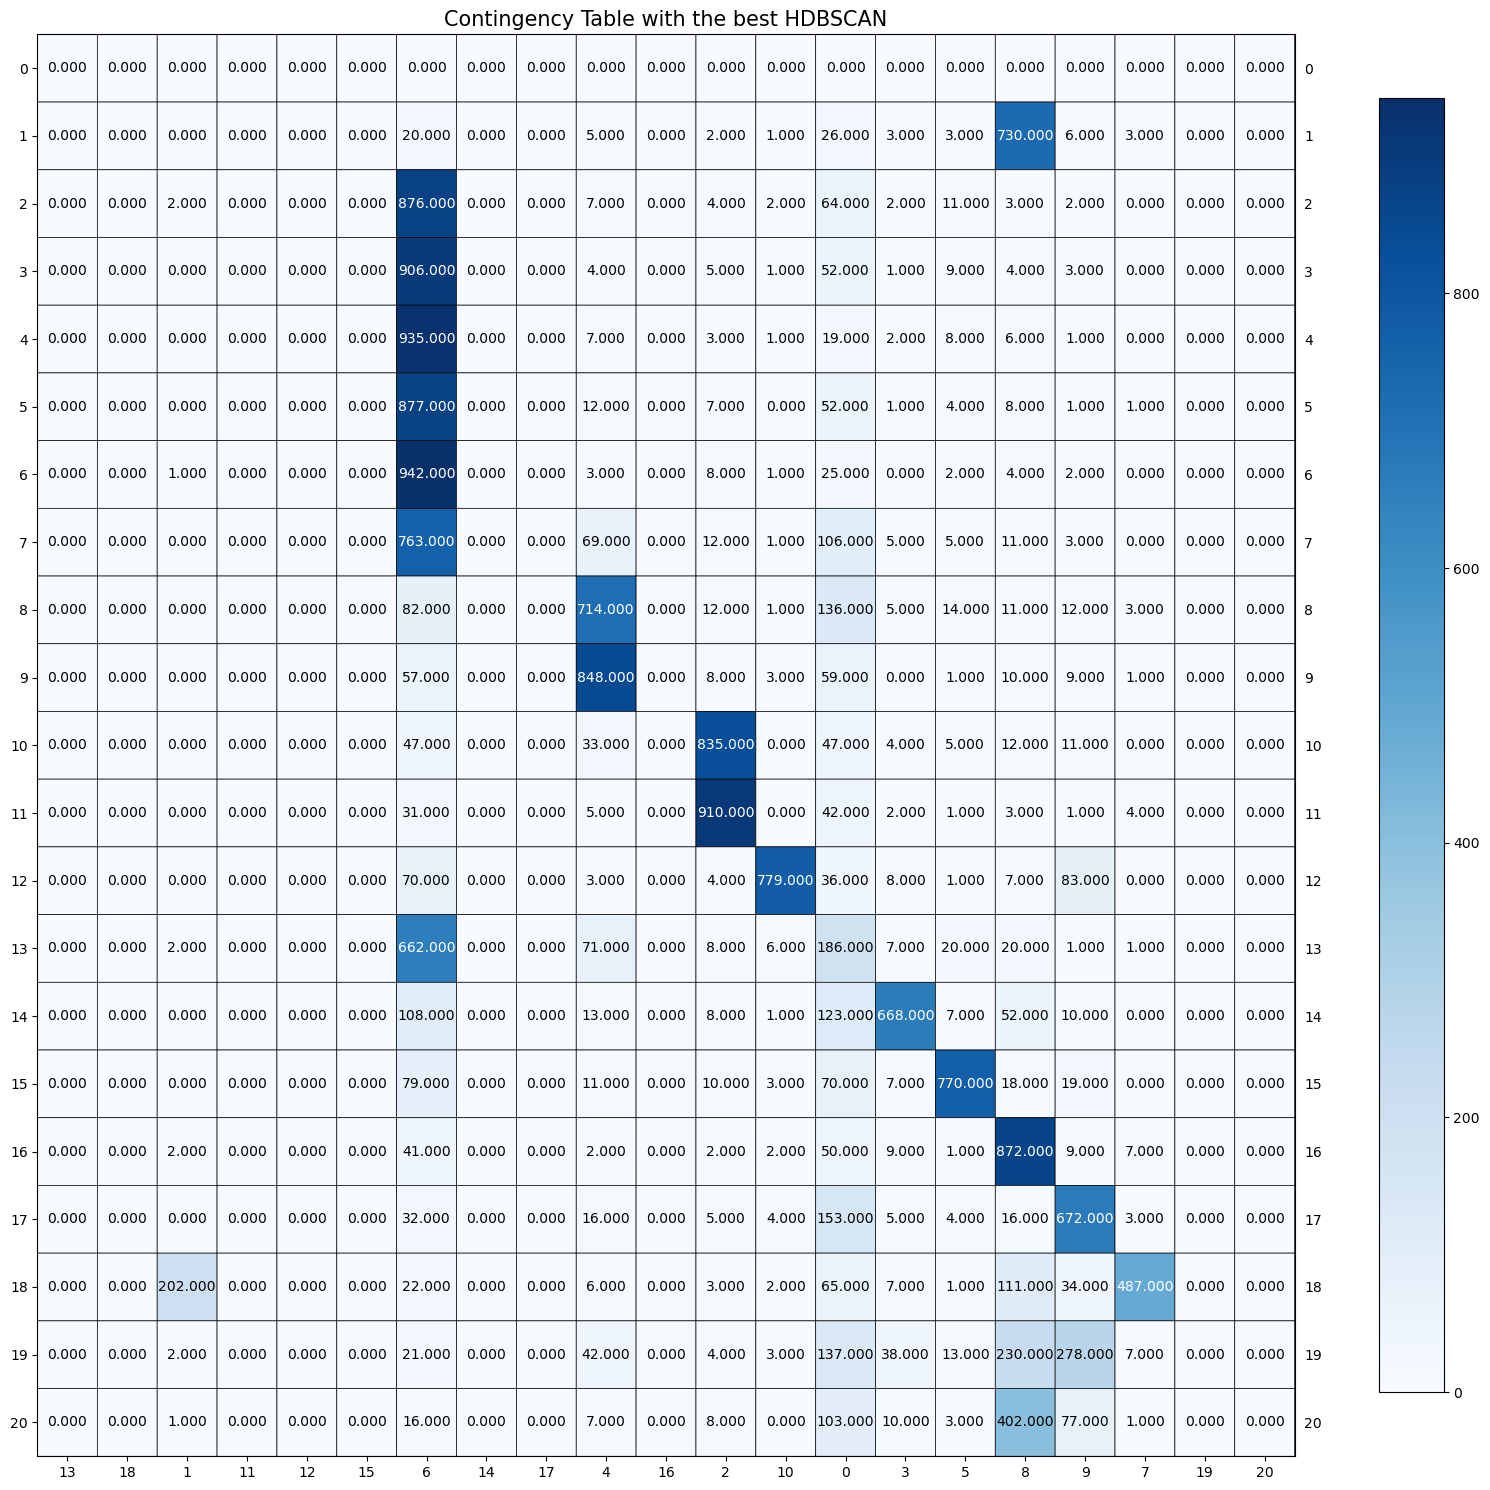

Metrics of the best HDBSCAN:

Homogeneity score: 0.4315150495121021
Completeness score: 0.6326596682760673
V-measure score: 0.5130777183804512
Adjusted Rand score: 0.23882282736623392
Adjusted mutual information score: 0.5120948861112418

Score averaged: 0.4656340299292193

This optimal HDBSCAN produces 11 clusters.


In [ ]:
key = comb_opt

hdbscan_opt = hdbscan_dict[key]
preds = hdbscan_preds_dict[key]

num_clusters = len(list(set(hdbscan_opt.labels_.tolist()))) # number of clusters

cm = confusion_matrix(class_labels, preds)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols],
         xticklabels=cols,
         yticklabels=rows,
         title = f"Contingency Table with the best HDBSCAN",
         size=(15, 15))

print(f"Metrics of the best HDBSCAN:\n")
print(f"Homogeneity score: {homo_score_dict[key]}")
print(f"Completeness score: {comp_score_dict[key]}")
print(f"V-measure score: {v_measure_dict[key]}")
print(f"Adjusted Rand score: {rand_index_dict[key]}")
print(f"Adjusted mutual information score: {mutual_info_score_dict[key]}")
score_avg = np.mean(np.array([homo_score_dict[key],
                                          comp_score_dict[key],
                                          v_measure_dict[key],
                                          rand_index_dict[key],
                                          mutual_info_score_dict[key]]))
print(f"\nScore averaged: {score_avg}\n")

print(f"This optimal HDBSCAN produces {num_clusters} clusters.")

### <strong>Question 17</strong><br>
As shown by the result, the best combination is "DimReduction Method: UMAP with r = 20, Clustering Method: K-Means with k = 20" and it gives the highest average score of 0.5636622002483677.

In [ ]:
X_tfidf_sparse = X_tfidf # sparse TF-IDF of all 20 classes obtained in Question 10

DimReduceMethod_ls = ["None", "SVD", "NMF", "UMAP"]
ClusteringMethod_ls = ["K-Means", "Agglomerative Clustering", "HDBSCAN"]

r_ls = [5, 20, 200]
k_ls = [10, 20, 50]
num_clusters_ls = [20]
mini_cluster_size_ls = [100, 200]

ScoreAvg_dict = {}
preds_dict = {}

for DimReduceMethod in DimReduceMethod_ls:
    if DimReduceMethod == "None":
        X_dense = get_dense_representation(X_sparse=X_tfidf_sparse, DimReduceMethod=DimReduceMethod)
        for ClusteringMethod in ClusteringMethod_ls:
            if ClusteringMethod == "K-Means":
                for k in k_ls:
                    try:
                        preds = get_preds(X_dense=X_dense, ClusteringMethod=ClusteringMethod, k=k)
                        score_avg = get_ScoreAvg(class_labels, preds)
                        ScoreAvg_dict.update({f"Average Score for DimReduction Method: {DimReduceMethod}, Clustering Method: {ClusteringMethod} with k = {k}": score_avg})
                        preds_dict.update({f"Average Score for DimReduction Method: {DimReduceMethod}, Clustering Method: {ClusteringMethod} with k = {k}": preds})
                        print(f"Average Score for DimReduction Method: {DimReduceMethod}, Clustering Method: {ClusteringMethod} with k = {k} is \n{score_avg}\n")
                    except TypeError:
                        print(f"Error: Without Dense data, cannot generate results for {ClusteringMethod} with k={k}!\n")
            elif ClusteringMethod == "Agglomerative Clustering":
                for num_clusters in num_clusters_ls:
                    try:
                        preds = get_preds(X_dense=X_dense, ClusteringMethod=ClusteringMethod, num_clusters=num_clusters)
                        score_avg = get_ScoreAvg(class_labels, preds)
                        ScoreAvg_dict.update({f"Average Score for DimReduction Method: {DimReduceMethod}, Clustering Method: {ClusteringMethod} with n_clusters = {num_clusters}": score_avg})
                        preds_dict.update({f"Average Score for DimReduction Method: {DimReduceMethod}, Clustering Method: {ClusteringMethod} with n_clusters = {num_clusters}": preds})
                        print(f"Average Score for DimReduction Method: {DimReduceMethod}, Clustering Method: {ClusteringMethod} with n_clusters = {num_clusters} is \n{score_avg}\n")
                    except TypeError:
                        print(f"Error: Without Dense data, cannot generate results for {ClusteringMethod} with num_clusters={num_clusters}!\n")
            else:
                for mini_cluster_size in mini_cluster_size_ls:
                    try:
                        preds = get_preds(X_dense=X_dense, ClusteringMethod=ClusteringMethod, mini_cluster_size=mini_cluster_size)
                        score_avg = get_ScoreAvg(class_labels, preds)
                        ScoreAvg_dict.update({f"Average Score for DimReduction Method: {DimReduceMethod}, Clustering Method: {ClusteringMethod} with min_cluster_size = {mini_cluster_size}": score_avg})
                        preds_dict.update({f"Average Score for DimReduction Method: {DimReduceMethod}, Clustering Method: {ClusteringMethod} with min_cluster_size = {mini_cluster_size}": preds})
                        print(f"Average Score for DimReduction Method: {DimReduceMethod}, Clustering Method: {ClusteringMethod} with min_cluster_size = {mini_cluster_size} is \n{score_avg}\n")
                    except TypeError:
                        print(f"Error: Without Dense data, cannot generate results for {ClusteringMethod} with min_cluster_size={mini_cluster_size}!\n")
    else:
        for r in r_ls:
            X_dense = get_dense_representation(X_sparse=X_tfidf_sparse, DimReduceMethod=DimReduceMethod, r=r)
            for ClusteringMethod in ClusteringMethod_ls:
                if ClusteringMethod == "K-Means":
                    for k in k_ls:
                        preds = get_preds(X_dense=X_dense, ClusteringMethod=ClusteringMethod, k=k)
                        score_avg = get_ScoreAvg(class_labels, preds)
                        ScoreAvg_dict.update({f"Average Score for DimReduction Method: {DimReduceMethod} with r = {r}, Clustering Method: {ClusteringMethod} with k = {k}": score_avg})
                        preds_dict.update({f"Average Score for DimReduction Method: {DimReduceMethod} with r = {r}, Clustering Method: {ClusteringMethod} with k = {k}": preds})
                        print(f"Average Score for DimReduction Method: {DimReduceMethod} with r = {r}, Clustering Method: {ClusteringMethod} with k = {k} is \n{score_avg}\n")
                elif ClusteringMethod == "Agglomerative Clustering":
                    for num_clusters in num_clusters_ls:
                        preds = get_preds(X_dense=X_dense, ClusteringMethod=ClusteringMethod, num_clusters=num_clusters)
                        score_avg = get_ScoreAvg(class_labels, preds)
                        ScoreAvg_dict.update({f"Average Score for DimReduction Method: {DimReduceMethod} with r = {r}, Clustering Method: {ClusteringMethod} with n_clusters = {num_clusters}": score_avg})
                        preds_dict.update({f"Average Score for DimReduction Method: {DimReduceMethod} with r = {r}, Clustering Method: {ClusteringMethod} with n_clusters = {num_clusters}": preds})
                        print(f"Average Score for DimReduction Method: {DimReduceMethod} with r = {r}, Clustering Method: {ClusteringMethod} with n_clusters = {num_clusters} is \n{score_avg}\n")
                else:
                    for mini_cluster_size in mini_cluster_size_ls:
                        preds = get_preds(X_dense=X_dense, ClusteringMethod=ClusteringMethod, mini_cluster_size=mini_cluster_size)
                        score_avg = get_ScoreAvg(class_labels, preds)
                        ScoreAvg_dict.update({f"Average Score for DimReduction Method: {DimReduceMethod} with r = {r}, Clustering Method: {ClusteringMethod} with min_cluster_size = {mini_cluster_size}": score_avg})
                        preds_dict.update({f"Average Score for DimReduction Method: {DimReduceMethod} with r = {r}, Clustering Method: {ClusteringMethod} with min_cluster_size = {mini_cluster_size}": preds})
                        print(f"Average Score for DimReduction Method: {DimReduceMethod} with r = {r}, Clustering Method: {ClusteringMethod} with min_cluster_size = {mini_cluster_size} is \n{score_avg}\n")


TheKey = max(ScoreAvg_dict, key=ScoreAvg_dict.get)
print(f"\nTHE OPTIMAL RESULT:\n {TheKey} is \n{ScoreAvg_dict[TheKey]}")



Average Score for DimReduction Method: None, Clustering Method: K-Means with k = 10 is 
0.28877139073908226

Average Score for DimReduction Method: None, Clustering Method: K-Means with k = 20 is 
0.32994359652349486

Average Score for DimReduction Method: None, Clustering Method: K-Means with k = 50 is 
0.36437836006531155

Error: Without Dense data, cannot generate results for Agglomerative Clustering with num_clusters=20!

Average Score for DimReduction Method: None, Clustering Method: HDBSCAN with min_cluster_size = 100 is 
0.0020780798159691217

Average Score for DimReduction Method: None, Clustering Method: HDBSCAN with min_cluster_size = 200 is 
0.0026813654502729793

Average Score for DimReduction Method: SVD with r = 5, Clustering Method: K-Means with k = 10 is 
0.2895817322203181

Average Score for DimReduction Method: SVD with r = 5, Clustering Method: K-Means with k = 20 is 
0.29515695931375646

Average Score for DimReduction Method: SVD with r = 5, Clustering Method: K-Mea

We also reported the Contingency Table together with measure scores associated with this optimal combination.

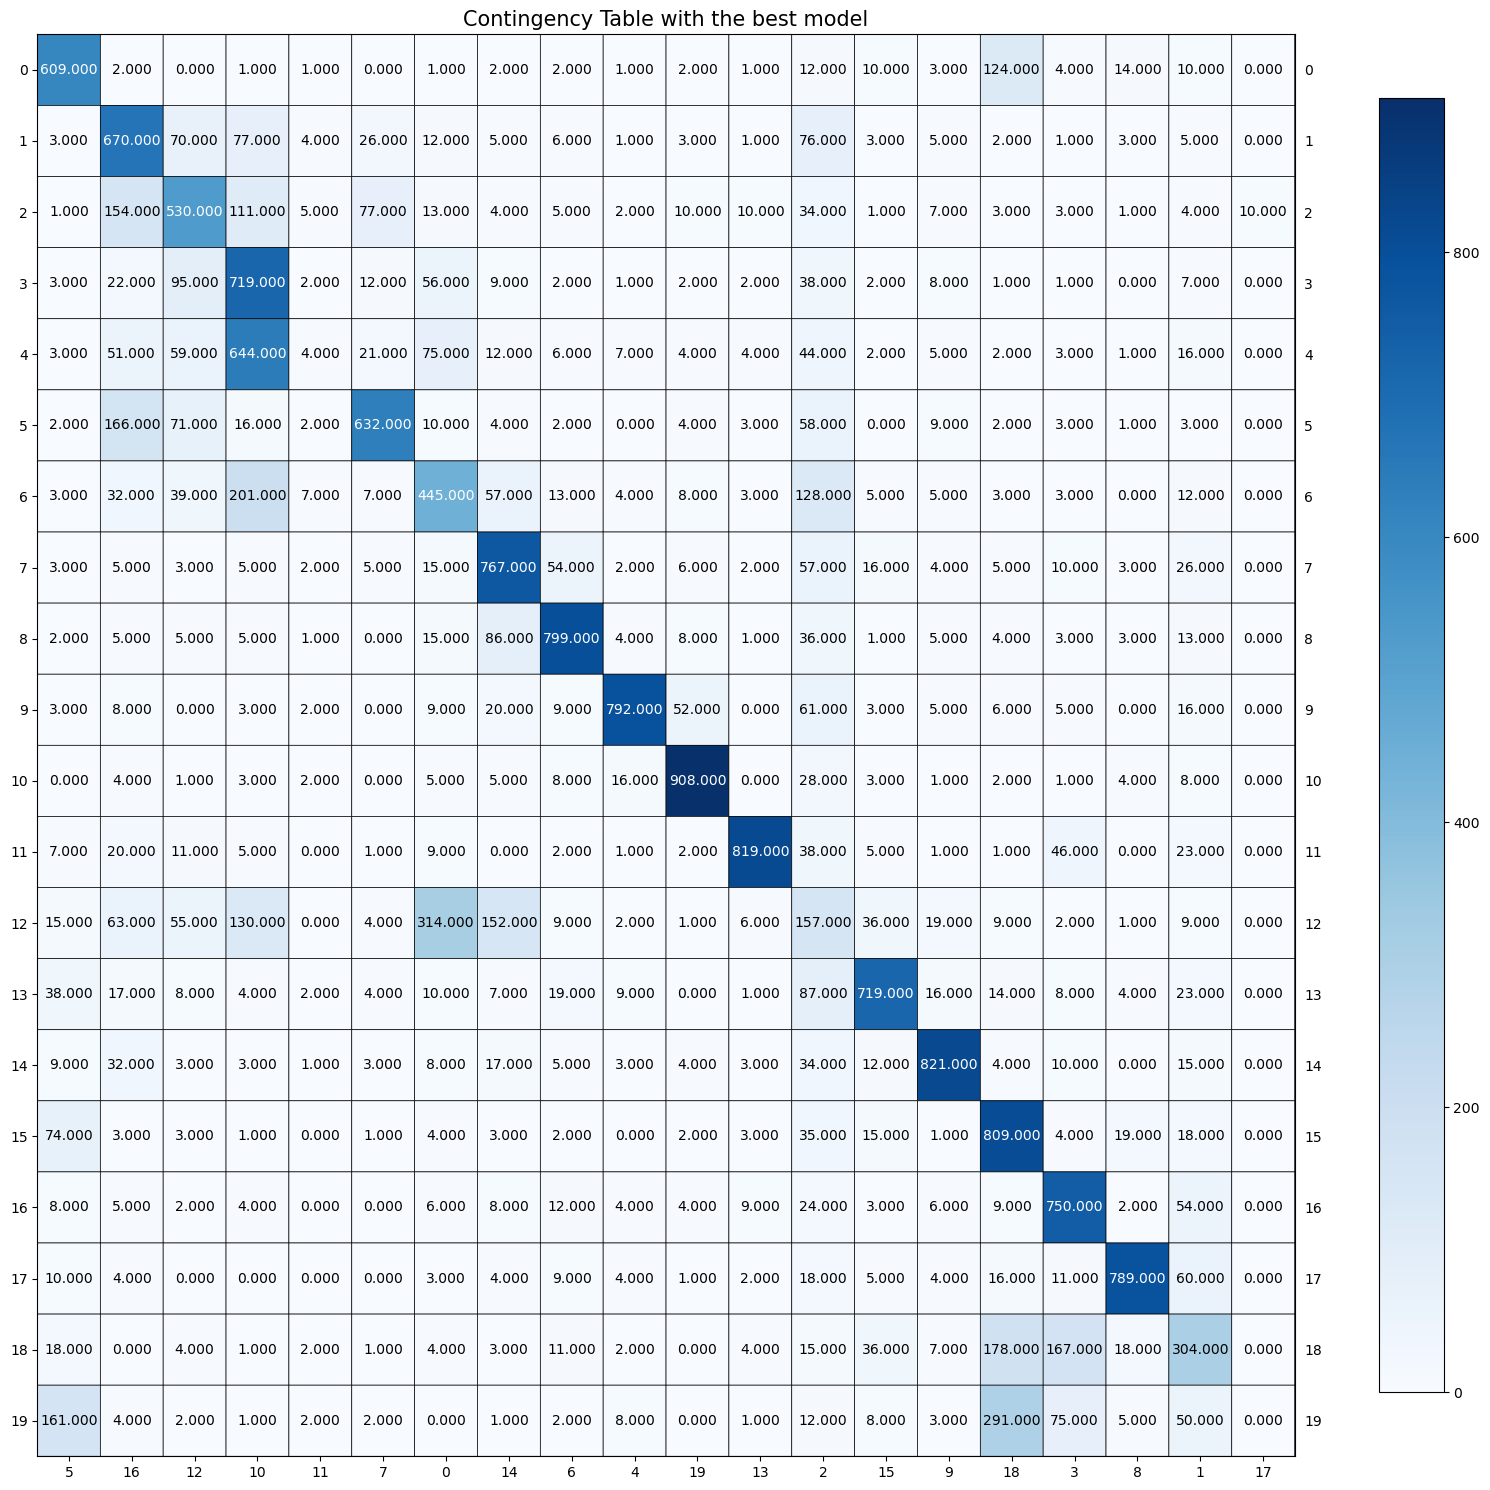

Metrics of the best model:


Homogeneity Score: 0.575640347397702
Completeness: 0.5996513506299366
V-measurement: 0.5874005787216927
Adjust Rand Index: 0.46958855434302416
Adjusted mutual information score: 0.5860301701494828

Score on Average: 0.5636622002483677


In [ ]:
preds_opt = preds_dict[TheKey]

cm = confusion_matrix(class_labels, preds_opt)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols],
         xticklabels=cols,
         yticklabels=rows,
         title = f"Contingency Table with the best model",
         size=(15, 15))

homo_score = homogeneity_score(class_labels, preds_opt)
comp_score = completeness_score(class_labels, preds_opt)
v_measure = v_measure_score(class_labels, preds_opt)
rand_index = adjusted_rand_score(class_labels, preds_opt)
mutual_info_score = adjusted_mutual_info_score(class_labels, preds_opt)

ScoreAvg = np.mean(np.array([homo_score,
                             comp_score,
                             v_measure,
                             rand_index,
                             mutual_info_score]))

print(f"Metrics of the best model:\n\n")
print(f"Homogeneity Score: {homo_score}")
print(f"Completeness: {comp_score}")
print(f"V-measurement: {v_measure}")
print(f"Adjust Rand Index: {rand_index}")
print(f"Adjusted mutual information score: {mutual_info_score}")
print(f"\nScore on Average: {ScoreAvg}")


### <strong>Question 18</strong>
<p>In dimension reduction, we could replace UMAP with Random Forest (RF) and see whether it is a better option. The following merits of RF let us believe that it is worthy of a try:</p>
<p>(1) Variable Importance: random Forest calculates the importance of each feature in building the trees of the forest. This importance score can be used as a criterion for selecting the most relevant features. Features with higher importance are likely to contribute more to the prediction, while features with lower importance can be discarded, aiding in dimensionality reduction.</p>
<p>(2) Outlier Robustness: Random Forest is relatively robust to outliers and noisy data. In dimension reduction, this can be advantageous as outliers in high-dimensional space can significantly affect the performance of traditional dimensionality reduction techniques. By averaging predictions over multiple trees, Random Forest can mitigate the impact of outliers on feature selection.</p>

### <strong>Question 19</strong><br>
This is the relationship between training task and downstream task. In the traing process of VGG using classes, the VGG network can learn the the evaluation criterions through network training. This evaluation criterions are the feature vectors construsted using the hidden layers of VGG network. After training on the classes VGG network can also use these features it learned on a custom dataset to discriminate them.

### <strong>Question 20</strong> <br>
In the feature extraction part of the helper code, there are four parts in feature extraction. First taking input x into the VGG-16 Feature Layers, then taking the output to VGG-16 Average Pooling Layer. After that, we convert the image into one-dimensional vector and using the first part of fully-connected layer from VGG16 to get the feature vectors.

In [3]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

In [4]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out)
            return out

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()
    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 167MB/s]
100%|██████████| 58/58 [00:17<00:00,  3.24it/s]


In [5]:
f_all

array([[-4.84260798, -0.86443853,  1.16131222, ..., -5.53722   ,
        -0.65415621,  0.06776109],
       [-1.01787603, -2.14714313,  2.34580803, ..., -3.57743001,
        -0.50622332, -2.12912512],
       [-3.10237479,  0.02004268,  0.66657567, ...,  1.46020949,
         0.29620442,  0.83325154],
       ...,
       [-2.71479011, -1.86127448, -0.53858018, ..., -5.23033142,
         2.47445679,  0.77031934],
       [-0.84451264, -2.31254911,  2.47856379, ..., -2.87514329,
        -1.07897878, -2.95777702],
       [-1.70073938, -0.03803721,  2.18148613, ..., -0.14825368,
         1.66635728,  0.4763048 ]])

In [6]:
y_all

array([1., 1., 1., ..., 3., 4., 3.])

### <strong>Question 21</strong><br>
There are $224*224*3$ pixels in all of the original images. VGG network extract 4096 features per image.

In [7]:
print(f_all[1].shape)
num_features = f_all.shape[1]

(4096,)


### <strong>Question 22</strong><br>
From the following 2-Dimension PCA plot we can know that the extracted features are dense.

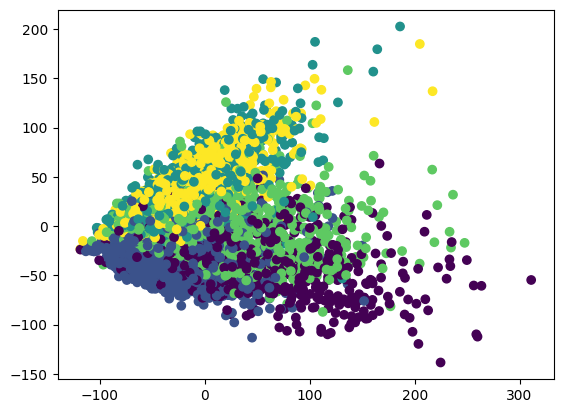

In [8]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

### <strong>Question 23</strong>
Although there are still some overlapping points, t-SNE has effectively transformed the high-dimensional VGG feature vectors into five clusters in the classification.

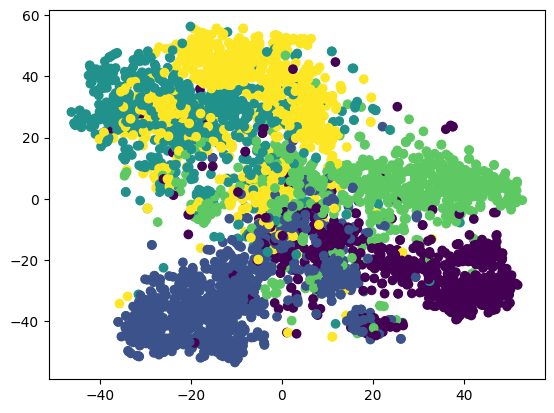

In [9]:
from sklearn.manifold import TSNE
f_pca = TSNE(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

### <strong>Question 24</strong><br>


In [10]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
import umap.umap_ as umap

In [11]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None

    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))

    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))

    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self

    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

- **Dimensionality Reduction:**

In [12]:
#Dimensionality Reduction（SVD UMAP Autoencoder）
# SVD
DR_SVD = TruncatedSVD(n_components=50)
DR_SVD_data = DR_SVD.fit_transform(f_all)
# UMAP
DR_UMAP = umap.UMAP(n_components=50, metric='cosine')
DR_UMAP_data = DR_UMAP.fit_transform(f_all)
# Autoencoder
DR_Autoencoder = Autoencoder(50)
DR_Autoencoder_data = DR_Autoencoder.fit_transform(f_all)

100%|██████████| 100/100 [00:08<00:00, 11.14it/s]


- **Clustering**
 - **K-mean**
 - **Agglomerative Clustering**
 - **HDBSCAN**

In [13]:
from sklearn.cluster import KMeans
from sklearn import metrics
import pandas as pd

# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=['Method', 'Rand Score'])

# KMeans without Dimensionality Reduction
km_NDR_pred = KMeans(n_clusters=5, n_init=30, max_iter=1000, random_state=42).fit_predict(f_all)
km_NDR_result = metrics.adjusted_rand_score(y_all, km_NDR_pred)
results_df = results_df.append({'Method': 'KMeans (No DR)', 'Rand Score': km_NDR_result}, ignore_index=True)

# KMeans with Dimensionality Reduction SVD
km_SVD_pred = KMeans(n_clusters=5, n_init=30, max_iter=1000, random_state=42).fit_predict(DR_SVD_data)
km_SVD_result = metrics.adjusted_rand_score(y_all, km_SVD_pred)
results_df = results_df.append({'Method': 'KMeans (SVD)', 'Rand Score': km_SVD_result}, ignore_index=True)

# KMeans with Dimensionality Reduction UMAP
km_UMAP_pred = KMeans(n_clusters=5, n_init=30, max_iter=1000, random_state=42).fit_predict(DR_UMAP_data)
km_UMAP_result = metrics.adjusted_rand_score(y_all, km_UMAP_pred)
results_df = results_df.append({'Method': 'KMeans (UMAP)', 'Rand Score': km_UMAP_result}, ignore_index=True)

# KMeans with Dimensionality Reduction Autoencoder
km_Autoencoder_pred = KMeans(n_clusters=5, n_init=30, max_iter=1000, random_state=42).fit_predict(DR_Autoencoder_data)
km_Autoencoder_result = metrics.adjusted_rand_score(y_all, km_Autoencoder_pred)
results_df = results_df.append({'Method': 'KMeans (Autoencoder)', 'Rand Score': km_Autoencoder_result}, ignore_index=True)

# Display the results
print(results_df)

<ipython-input-13-43da78eceeef>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': 'KMeans (No DR)', 'Rand Score': km_NDR_result}, ignore_index=True)
<ipython-input-13-43da78eceeef>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': 'KMeans (SVD)', 'Rand Score': km_SVD_result}, ignore_index=True)
<ipython-input-13-43da78eceeef>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': 'KMeans (UMAP)', 'Rand Score': km_UMAP_result}, ignore_index=True)


                 Method  Rand Score
0        KMeans (No DR)    0.195216
1          KMeans (SVD)    0.193227
2         KMeans (UMAP)    0.468045
3  KMeans (Autoencoder)    0.215113


<ipython-input-13-43da78eceeef>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Method': 'KMeans (Autoencoder)', 'Rand Score': km_Autoencoder_result}, ignore_index=True)


In [14]:
results_df

Method  Rand Score
0        KMeans (No DR)    0.195216
1          KMeans (SVD)    0.193227
2         KMeans (UMAP)    0.468045
3  KMeans (Autoencoder)    0.215113

In [15]:
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
import pandas as pd

# Create a DataFrame to store the results
results_df_agg = pd.DataFrame(columns=['Method', 'Rand Score'])

# Agglomerative Clustering without Dimensionality Reduction
agg_NDR_pred = AgglomerativeClustering(n_clusters=5).fit_predict(f_all)
agg_NDR_result = metrics.adjusted_rand_score(y_all, agg_NDR_pred)
results_df_agg = results_df_agg.append({'Method': 'AgglomerativeClustering (No DR)', 'Rand Score': agg_NDR_result}, ignore_index=True)

# Agglomerative Clustering with Dimensionality Reduction SVD
agg_SVD_pred = AgglomerativeClustering(n_clusters=5).fit_predict(DR_SVD_data)
agg_SVD_result = metrics.adjusted_rand_score(y_all, agg_SVD_pred)
results_df_agg = results_df_agg.append({'Method': 'AgglomerativeClustering (SVD)', 'Rand Score': agg_SVD_result}, ignore_index=True)

# Agglomerative Clustering with Dimensionality Reduction UMAP
agg_UMAP_pred = AgglomerativeClustering(n_clusters=5).fit_predict(DR_UMAP_data)
agg_UMAP_result = metrics.adjusted_rand_score(y_all, agg_UMAP_pred)
results_df_agg = results_df_agg.append({'Method': 'AgglomerativeClustering (UMAP)', 'Rand Score': agg_UMAP_result}, ignore_index=True)

# Agglomerative Clustering with Dimensionality Reduction Autoencoder
agg_Autoencoder_pred = AgglomerativeClustering(n_clusters=5).fit_predict(DR_Autoencoder_data)
agg_Autoencoder_result = metrics.adjusted_rand_score(y_all, agg_Autoencoder_pred)
results_df_agg = results_df_agg.append({'Method': 'AgglomerativeClustering (Autoencoder)', 'Rand Score': agg_Autoencoder_result}, ignore_index=True)

# Display the results
print(results_df_agg)

<ipython-input-15-5b35882a4a46>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_agg = results_df_agg.append({'Method': 'AgglomerativeClustering (No DR)', 'Rand Score': agg_NDR_result}, ignore_index=True)
<ipython-input-15-5b35882a4a46>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_agg = results_df_agg.append({'Method': 'AgglomerativeClustering (SVD)', 'Rand Score': agg_SVD_result}, ignore_index=True)
<ipython-input-15-5b35882a4a46>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_agg = results_df_agg.append({'Method': 'AgglomerativeClustering (UMAP)', 'Rand Score': agg_UMAP_result}, ignore_index=True)


                                  Method  Rand Score
0        AgglomerativeClustering (No DR)    0.211929
1          AgglomerativeClustering (SVD)    0.209225
2         AgglomerativeClustering (UMAP)    0.476569
3  AgglomerativeClustering (Autoencoder)    0.245543


<ipython-input-15-5b35882a4a46>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_agg = results_df_agg.append({'Method': 'AgglomerativeClustering (Autoencoder)', 'Rand Score': agg_Autoencoder_result}, ignore_index=True)


In [16]:
results_df_agg

Method  Rand Score
0        AgglomerativeClustering (No DR)    0.211929
1          AgglomerativeClustering (SVD)    0.209225
2         AgglomerativeClustering (UMAP)    0.476569
3  AgglomerativeClustering (Autoencoder)    0.245543

In [17]:
!pip install seaborn
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 45.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039282 sha256=f46fcf9932408d60d2c13b9be9f780a1b1b8ddb3de5107208f15359a0c38c70a
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.8
    Uninstalling Cython-3.0.8:
      Successfully uninstalled Cython-3.0.8


In [18]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
import hdbscan

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV

In [19]:
mcs_list = [5,10,20]
ms_list = [1,2,3]
best_score = 0
min_cluster_size = 0
min_samples = 0
results_df_agg = pd.DataFrame(columns=['Method', 'Rand Score', 'min_samples', 'min_cluster_size'])
#Without dimensinality reduction
for i in mcs_list:
  for j in ms_list:
    hdbs_model = hdbscan.HDBSCAN(min_cluster_size=i, min_samples=j )
    hdbs_pred = hdbs_model.fit_predict(f_all)
    hdbs_result = metrics.adjusted_rand_score(y_all, hdbs_pred)
    if hdbs_result>best_score:
      best_score=hdbs_result
      min_cluster_size=i
      min_samples=j
results_df_agg = results_df_agg.append({'Method': 'HDBSCAN (No DR)', 'Rand Score': best_score, 'min_cluster_size': min_cluster_size, 'min_samples': min_samples}, ignore_index=True)

<ipython-input-19-6b97e9438e57>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_agg = results_df_agg.append({'Method': 'HDBSCAN (No DR)', 'Rand Score': best_score, 'min_cluster_size': min_cluster_size, 'min_samples': min_samples}, ignore_index=True)


In [20]:
best_score = 0
min_cluster_size = 0
min_samples = 0
#With Dimensionality Reduction SVD
for i in mcs_list:
  for j in ms_list:
    hdbs_model = hdbscan.HDBSCAN(min_cluster_size=i, min_samples=j )
    hdbs_pred = hdbs_model.fit_predict(DR_SVD_data)
    hdbs_result = metrics.adjusted_rand_score(y_all, hdbs_pred)
    if hdbs_result>best_score:
      best_score=hdbs_result
      min_cluster_size=i
      min_samples=j
results_df_agg = results_df_agg.append({'Method': 'HDBSCAN (SVD)', 'Rand Score': best_score, 'min_cluster_size': min_cluster_size, 'min_samples': min_samples}, ignore_index=True)


<ipython-input-20-5f09c402db8f>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_agg = results_df_agg.append({'Method': 'HDBSCAN (SVD)', 'Rand Score': best_score, 'min_cluster_size': min_cluster_size, 'min_samples': min_samples}, ignore_index=True)


In [21]:
best_score = 0
min_cluster_size = 0
min_samples = 0
#With Dimensionality Reduction UMAP
for i in mcs_list:
  for j in ms_list:
    hdbs_model = hdbscan.HDBSCAN(min_cluster_size=i, min_samples=j )
    hdbs_pred = hdbs_model.fit_predict(DR_UMAP_data)
    hdbs_result = metrics.adjusted_rand_score(y_all, hdbs_pred)
    if hdbs_result>best_score:
      best_score=hdbs_result
      min_cluster_size=i
      min_samples=j
results_df_agg = results_df_agg.append({'Method': 'HDBSCAN (UMAP)', 'Rand Score': best_score, 'min_cluster_size': min_cluster_size, 'min_samples': min_samples}, ignore_index=True)

<ipython-input-21-dff7982216f6>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_agg = results_df_agg.append({'Method': 'HDBSCAN (UMAP)', 'Rand Score': best_score, 'min_cluster_size': min_cluster_size, 'min_samples': min_samples}, ignore_index=True)


In [22]:
best_score = 0
min_cluster_size = 0
min_samples = 0
#With Dimensionality Reduction Autoencoder
for i in mcs_list:
  for j in ms_list:
    hdbs_model = hdbscan.HDBSCAN(min_cluster_size=i, min_samples=j )
    hdbs_pred = hdbs_model.fit_predict(DR_Autoencoder_data)
    hdbs_result = metrics.adjusted_rand_score(y_all, hdbs_pred)
    print(f"HDBSCAN with Dimensionality Reduction Autoencoder: \n the min cluster size is {i}, the min samples is {j}, the rand score is {hdbs_result}")
    if hdbs_result>best_score:
      best_score=hdbs_result
      min_cluster_size=i
      min_samples=j
results_df_agg = results_df_agg.append({'Method': 'HDBSCAN (Autoencoder)', 'Rand Score': best_score, 'min_cluster_size': min_cluster_size, 'min_samples': min_samples}, ignore_index=True)

HDBSCAN with Dimensionality Reduction Autoencoder: 
 the min cluster size is 5, the min samples is 1, the rand score is 0.003432823038511647
HDBSCAN with Dimensionality Reduction Autoencoder: 
 the min cluster size is 5, the min samples is 2, the rand score is 0.012283178972851876
HDBSCAN with Dimensionality Reduction Autoencoder: 
 the min cluster size is 5, the min samples is 3, the rand score is 0.02604510862448644
HDBSCAN with Dimensionality Reduction Autoencoder: 
 the min cluster size is 10, the min samples is 1, the rand score is 0.016660758409403363
HDBSCAN with Dimensionality Reduction Autoencoder: 
 the min cluster size is 10, the min samples is 2, the rand score is 0.01664520821100067
HDBSCAN with Dimensionality Reduction Autoencoder: 
 the min cluster size is 10, the min samples is 3, the rand score is 0.03455623566671798
HDBSCAN with Dimensionality Reduction Autoencoder: 
 the min cluster size is 20, the min samples is 1, the rand score is -6.132161547139303e-05
HDBSCAN wi

<ipython-input-22-97ea1e4f6be1>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_agg = results_df_agg.append({'Method': 'HDBSCAN (Autoencoder)', 'Rand Score': best_score, 'min_cluster_size': min_cluster_size, 'min_samples': min_samples}, ignore_index=True)


In [23]:
results_df_agg

Method  Rand Score min_samples min_cluster_size
0        HDBSCAN (No DR)    0.016254           2                5
1          HDBSCAN (SVD)    0.026008           3                5
2         HDBSCAN (UMAP)    0.187701           1                5
3  HDBSCAN (Autoencoder)    0.034556           3               10

### <strong>Question 25</strong><br>
__The test accuracy of the MLP classifier on the original VGG features is 0.79, but the test accuracies of the MLP classifier on reduced-dimension features using SVD, UMAP, and Autoencoder methods are 0.25, 0.26, and 0.17, respectively. The performance of the model suffer with the reduced-dimension representations significantly.The success in classification makes sense in the context of clustering result in Question 24. In that question the clustering using UMAP dimensionality reduction method achieves the best performance among other methods. This is because clustering process is unsupervised learning and classification using MLP network is supervised learning.So they have different parameter setting strategies.__

In [24]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True),
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()


    def forward(self, X):
        return self.model(X)

    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()

        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                ##################################
                # you should implement this part #
                ##################################
                self.model.train()
                inputs, labels = X_,y_

                optimizer.zero_grad()

                outputs = self.model(inputs)

                batch_loss = criterion(outputs, labels)

                batch_loss.backward()

                optimizer.step()

        #raise NotImplementedError
        return self

    def eval(self, X_test, y_test):
        ##################################
        # you should implement this part #
        ##################################
        self.model.eval()
        X_test = torch.tensor(X_test, dtype=torch.float32, device='cuda')
        y_test = torch.tensor(y_test, dtype=torch.int64, device='cuda')
        output = self.model(X_test)
        _, predict_label = torch.max(output,1)
        correct_pred = torch.sum(predict_label==y_test)
        print(f"accuracy:{correct_pred/len(y_test):.2f}")
        return self

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    f_all,
    y_all,
    test_size=0.2,
    random_state=42)

In [26]:
model=MLP(num_features = f_all.shape[1])
model.train(X_train,y_train)

100%|██████████| 100/100 [00:05<00:00, 17.54it/s]


MLP(
  (model): Sequential(
    (0): Linear(in_features=4096, out_features=1280, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1280, out_features=640, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=640, out_features=5, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

In [27]:
model.eval(X_test,y_test)

accuracy:0.91


MLP(
  (model): Sequential(
    (0): Linear(in_features=4096, out_features=1280, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1280, out_features=640, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=640, out_features=5, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

In [28]:
X_train_SVD = DR_SVD.fit_transform(X_train)
X_test_SVD = DR_SVD.fit_transform(X_test)
model=MLP(num_features =X_train_SVD.shape[1])
model.train(X_train_SVD,y_train)

100%|██████████| 100/100 [00:05<00:00, 17.58it/s]


MLP(
  (model): Sequential(
    (0): Linear(in_features=50, out_features=1280, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1280, out_features=640, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=640, out_features=5, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

In [29]:
model.eval(X_test_SVD,y_test)

accuracy:0.63


MLP(
  (model): Sequential(
    (0): Linear(in_features=50, out_features=1280, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1280, out_features=640, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=640, out_features=5, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

In [32]:
X_train_UMAP = DR_UMAP.fit_transform(X_train)
X_test_UMAP = DR_UMAP.fit_transform(X_test)
model=MLP(num_features = X_train_UMAP.shape[1])
model.train(X_train_UMAP,y_train)

100%|██████████| 100/100 [00:05<00:00, 17.35it/s]


MLP(
  (model): Sequential(
    (0): Linear(in_features=50, out_features=1280, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1280, out_features=640, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=640, out_features=5, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

In [33]:
model.eval(X_test_UMAP,y_test)

accuracy:0.36


MLP(
  (model): Sequential(
    (0): Linear(in_features=50, out_features=1280, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1280, out_features=640, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=640, out_features=5, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

In [34]:
X_train_Autoencoder = DR_Autoencoder.fit_transform(X_train)
X_test_Autoencoder = DR_Autoencoder.fit_transform(X_test)
model=MLP(num_features = X_train_Autoencoder.shape[1])
model.train(X_train_Autoencoder,y_train)

100%|██████████| 100/100 [00:05<00:00, 17.27it/s]


MLP(
  (model): Sequential(
    (0): Linear(in_features=50, out_features=1280, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1280, out_features=640, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=640, out_features=5, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

In [35]:
model.eval(X_test_Autoencoder,y_test)

accuracy:0.17


MLP(
  (model): Sequential(
    (0): Linear(in_features=50, out_features=1280, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1280, out_features=640, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=640, out_features=5, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

### <strong>Question 26</strong>

In [36]:
!pip install datasets transformers numpy pandas Pillow matplotlib
!pip install torch tqdm scipy
!pip install git+https://github.com/openai/CLIP.git
!pip install plotly umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.1 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-wrs87mjb
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-wrs87mjb
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.9 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=444ff4b4071809a51b7794c5fc

In [37]:
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import clip
import torch
from tqdm import tqdm
from scipy.special import softmax
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE

In [38]:
import zipfile

uploaded_file_name = 'images.zip'

with zipfile.ZipFile(uploaded_file_name, 'r') as zip_ref:
    zip_ref.extractall('/content/')

extracted_files = !ls /content/
print("Extracted files:", extracted_files)

Extracted files: ['flower_photos\t\t\t images      __MACOSX\t Pokemon.csv  sample_data', 'flowers_features_and_labels.npz  images.zip  plotmat.py  __pycache__']


In [39]:
# load csv file and image paths to construct pokedex, use type_to_load=None to load all types, else use a list of types 1 to load
def construct_pokedex(csv_path='Pokemon.csv', image_dir='./images/', type_to_load=None):
    pokedex = pd.read_csv(csv_path)
    image_paths = []

    for pokemon_name in pokedex["Name"]:
        imgs = glob(f"{image_dir}/{pokemon_name}/0.jpg")
        if len(imgs) > 0:
            image_paths.append(imgs[0])
        else:
            image_paths.append(None)

    pokedex["image_path"] = image_paths
    pokedex = pokedex[pokedex["image_path"].notna()].reset_index(drop=True)

    # only keep pokemon with distinct id
    ids, id_counts = np.unique(pokedex["ID"], return_counts=True)
    ids, id_counts = np.array(ids), np.array(id_counts)
    keep_ids = ids[id_counts == 1]

    pokedex = pokedex[pokedex["ID"].isin(keep_ids)].reset_index(drop=True)
    pokedex["Type2"] = pokedex["Type2"].str.strip()
    if type_to_load is not None:
        pokedex = pokedex[pokedex["Type1"].isin(type_to_load)].reset_index(drop=True)
    return pokedex

# load clip model
def load_clip_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-L/14", device=device)
    return model, preprocess, device

# inference clip model on a list of image path
def clip_inference_image(model, preprocess, image_paths, device):
    image_embeddings = []
    with torch.no_grad():
        for img_path in tqdm(image_paths):
            img = Image.open(img_path)
            img_preprocessed = preprocess(img).unsqueeze(0).to(device)
            image_embedding = model.encode_image(img_preprocessed).detach().cpu().numpy()
            image_embeddings += [image_embedding]

    image_embeddings = np.concatenate(image_embeddings, axis=0)
    image_embeddings /= np.linalg.norm(image_embeddings, axis=-1, keepdims=True)
    return image_embeddings

# inference clip model on a list of texts
def clip_inference_text(model, preprocess, texts, device):
    with torch.no_grad():
        text_embeddings = model.encode_text(clip.tokenize(texts).to(device)).detach().cpu().numpy()
    text_embeddings /= np.linalg.norm(text_embeddings, axis=-1, keepdims=True)
    return text_embeddings


# compute similarity of texts to each image
def compute_similarity_text_to_image(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=0)
    return similarity


# compute similarity of iamges to each text
def compute_similarity_image_to_text(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=0)
    return similarity

# Use TSNE to project CLIP embeddings to 2D space
def umap_projection(image_embeddings, n_neighbors=15, min_dist=0.1, metric='cosine'):
    distance_matrix = np.zeros((image_embeddings.shape[0], image_embeddings.shape[0]))
    for i in range(image_embeddings.shape[0]):
        for j in range(image_embeddings.shape[0]):
            if i == j:
                distance_matrix[i, j] = 1
            else:
                distance_matrix[i, j] = np.dot(image_embeddings[i], image_embeddings[j])
    distance_matrix = 1 - distance_matrix
    reducer = TSNE(n_components=2, metric="precomputed", init="random", random_state=42)
    visualization_data = reducer.fit_transform(distance_matrix)
    return visualization_data

In [40]:
# Function to plot the top 5 relevant Pokemon for a given type
def plot_top5_relevant_pokemon(query, relevant_pokemon):
    plt.figure(figsize=(15, 5))
    plt.suptitle(query, fontsize=16)

    for i in range(min(5, len(relevant_pokemon))):
        pokemon_name = relevant_pokemon.iloc[i]["Name"]
        type1 = relevant_pokemon.iloc[i]["Type1"]
        type2 = relevant_pokemon.iloc[i]["Type2"]
        image_path = relevant_pokemon.iloc[i]["image_path"]

        img = Image.open(image_path)

        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(f"{pokemon_name}\n{type1} / {type2}")
        plt.axis("off")

    plt.show()

100%|███████████████████████████████████████| 890M/890M [00:10<00:00, 88.5MiB/s]
100%|██████████| 753/753 [00:15<00:00, 49.38it/s]


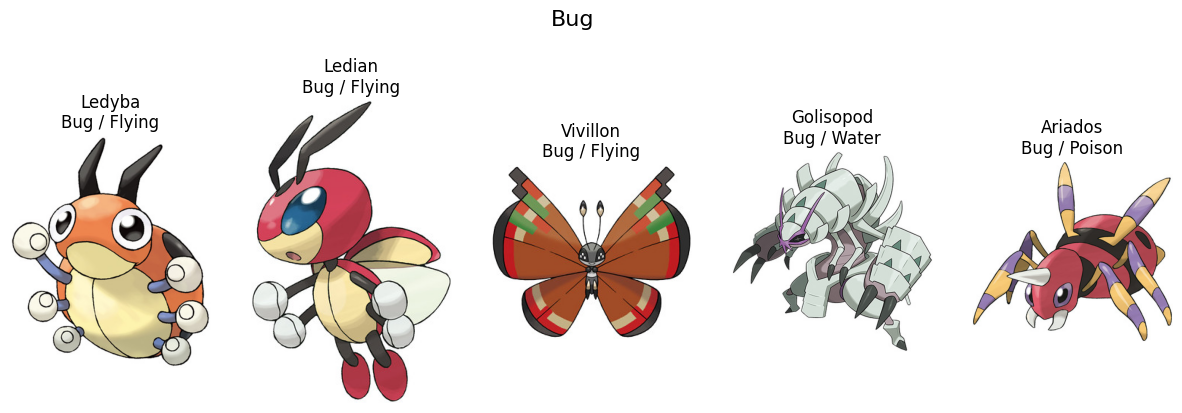

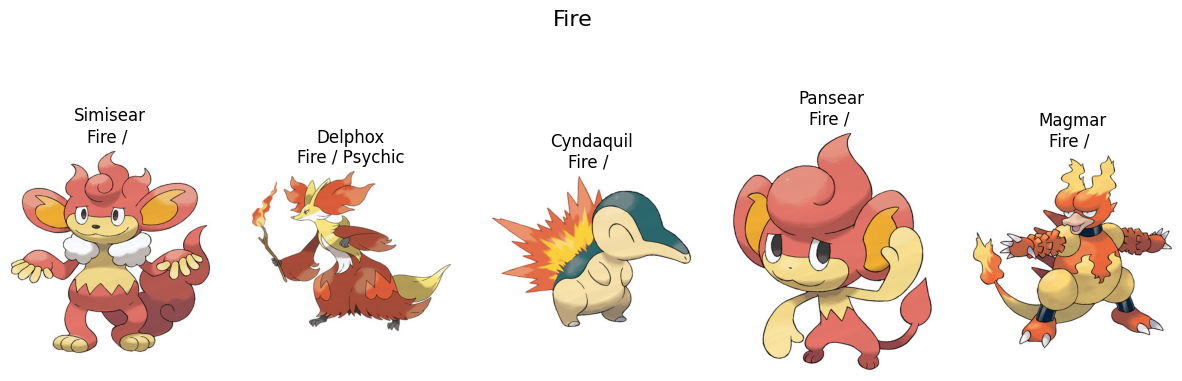

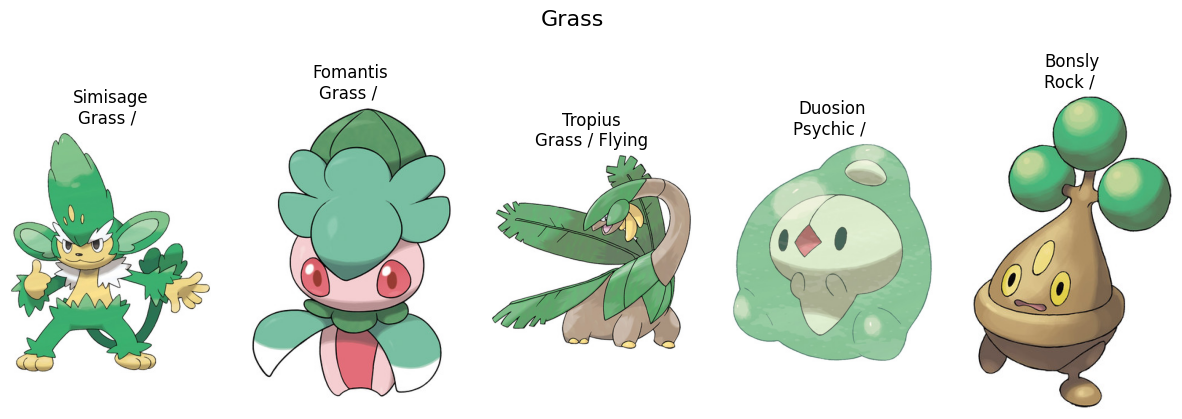

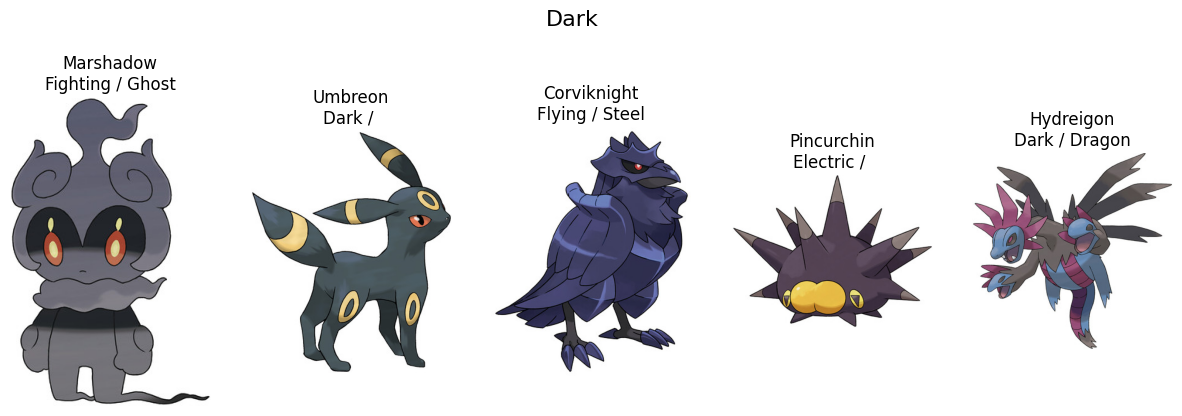

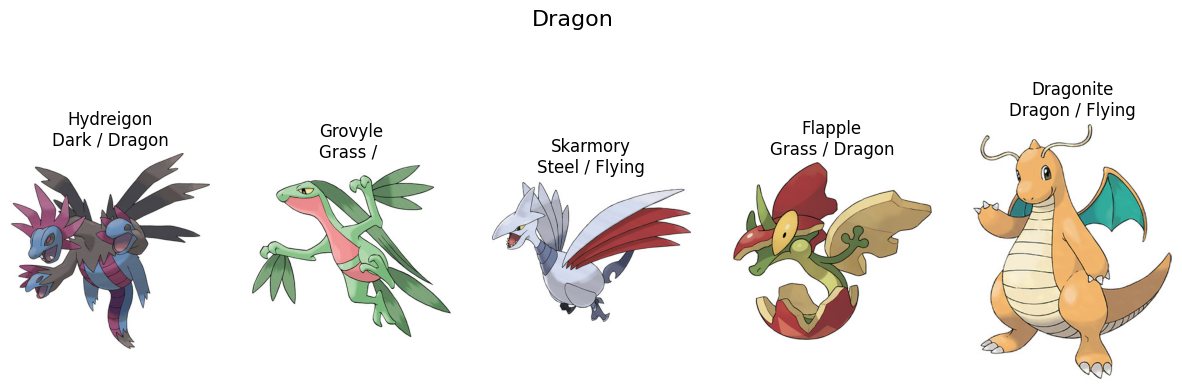

In [41]:
# Construct Pokedex
pokedex = construct_pokedex()

# Load CLIP model
model, preprocess, device = load_clip_model()

# Get image paths from the Pokedex
image_paths = pokedex["image_path"].values

# Inference image embeddings using CLIP
image_embeddings = clip_inference_image(model, preprocess, image_paths, device)

# Construct queries for Bug, Fire, Grass, Dark, and Dragon types
queries = ["Bug", "Fire", "Grass",
           "Dark", "Dragon"]
'''
queries = ["Bug type Pokemon", "Fire type Pokemon", "Grass type Pokemon",
           "Dark type Pokemon", "Dragon type Pokemon"]
'''
for query in queries:
    # Inference text embeddings for the query
    query_embedding = clip_inference_text(model, preprocess, [query], device)

    # Compute similarity between query and image embeddings
    similarity_scores = compute_similarity_text_to_image(image_embeddings, query_embedding) ###

    # Get the indices of the top 5 relevant Pokemon
    top5_indices = np.argsort(similarity_scores[:, 0])[::-1][:5]

    # Ensure top5_indices is a 1-dimensional array
    top5_indices = top5_indices.flatten()

    # Get the relevant Pokemon from the Pokedex
    relevant_pokemon = pokedex.iloc[top5_indices]

    # Plot the top 5 relevant Pokemon for the type
    plot_top5_relevant_pokemon(query, relevant_pokemon)

### <strong>Question 27</strong>

In [42]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels
    plt.show()

100%|██████████| 10/10 [00:00<00:00, 49.64it/s]


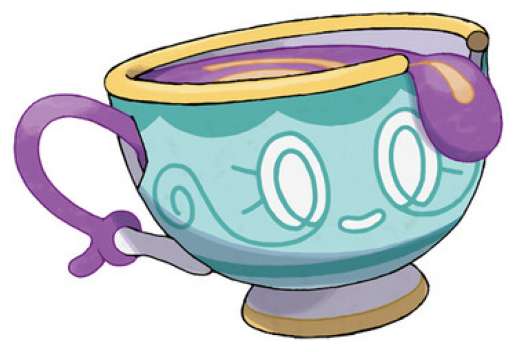

number of image:1
         Name  Type1 Type2
716  Sinistea  Ghost      
	
1:relevant types:type: Ghost , predicted probabilities:0.794921875
	
2:relevant types:type: Ice , predicted probabilities:0.494140625
	
3:relevant types:type: Psychic , predicted probabilities:0.435791015625
	
4:relevant types:type: Poison , predicted probabilities:0.3349609375
	
5:relevant types:type: Fairy , predicted probabilities:0.32763671875




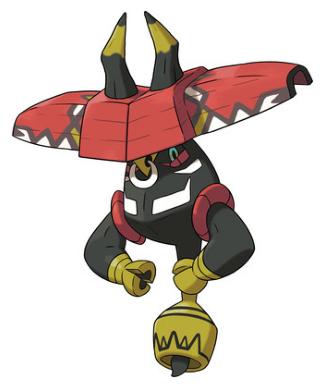

number of image:2
          Name  Type1  Type2
651  Tapu Bulu  Grass  Fairy
	
1:relevant types:type: Dark , predicted probabilities:0.5830078125
	
2:relevant types:type: Steel , predicted probabilities:0.365478515625
	
3:relevant types:type: Bug , predicted probabilities:0.353759765625
	
4:relevant types:type: Flying , predicted probabilities:0.348388671875
	
5:relevant types:type: Fire , predicted probabilities:0.237548828125




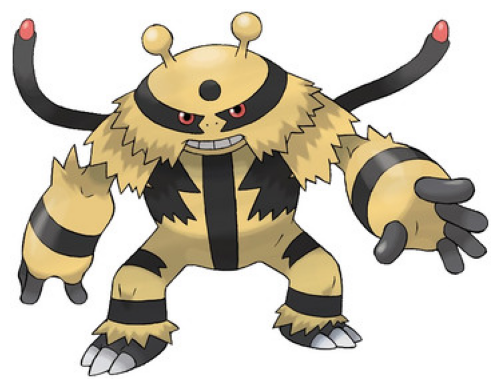

number of image:3
           Name     Type1 Type2
371  Electivire  Electric      
	
1:relevant types:type: Fighting , predicted probabilities:0.2281494140625
	
2:relevant types:type: Electric , predicted probabilities:0.215087890625
	
3:relevant types:type: Steel , predicted probabilities:0.147705078125
	
4:relevant types:type: Bug , predicted probabilities:0.1322021484375
	
5:relevant types:type: Dark , predicted probabilities:0.11474609375




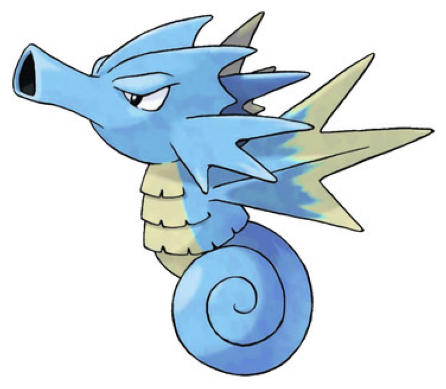

number of image:4
      Name  Type1 Type2
77  Seadra  Water      
	
1:relevant types:type: Dragon , predicted probabilities:0.9658203125
	
2:relevant types:type: Water , predicted probabilities:0.82861328125
	
3:relevant types:type: Normal , predicted probabilities:0.255859375
	
4:relevant types:type: Ice , predicted probabilities:0.2193603515625
	
5:relevant types:type: Fire , predicted probabilities:0.148681640625




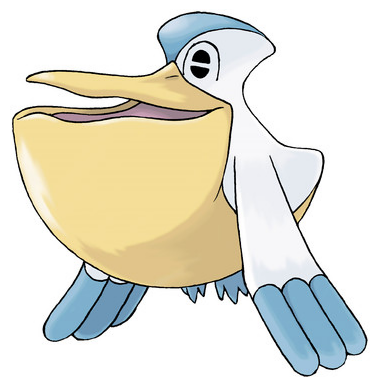

number of image:5
         Name  Type1   Type2
212  Pelipper  Water  Flying
	
1:relevant types:type: Flying , predicted probabilities:0.29345703125
	
2:relevant types:type: Fighting , predicted probabilities:0.207763671875
	
3:relevant types:type: Normal , predicted probabilities:0.19921875
	
4:relevant types:type: Ice , predicted probabilities:0.1605224609375
	
5:relevant types:type: Psychic , predicted probabilities:0.076904296875




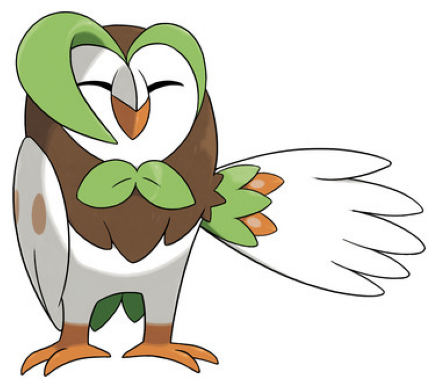

number of image:6
        Name  Type1   Type2
594  Dartrix  Grass  Flying
	
1:relevant types:type: Flying , predicted probabilities:0.1806640625
	
2:relevant types:type: Fire , predicted probabilities:0.11395263671875
	
3:relevant types:type: Fighting , predicted probabilities:0.10614013671875
	
4:relevant types:type: Fairy , predicted probabilities:0.06256103515625
	
5:relevant types:type: Psychic , predicted probabilities:0.050445556640625




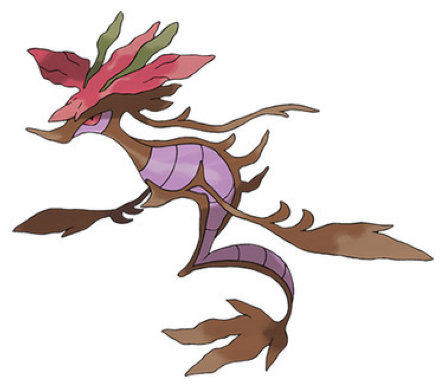

number of image:7
         Name   Type1   Type2
569  Dragalge  Poison  Dragon
	
1:relevant types:type: Grass , predicted probabilities:0.85693359375
	
2:relevant types:type: Ground , predicted probabilities:0.72900390625
	
3:relevant types:type: Fairy , predicted probabilities:0.414306640625
	
4:relevant types:type: Fire , predicted probabilities:0.281982421875
	
5:relevant types:type: Poison , predicted probabilities:0.26513671875




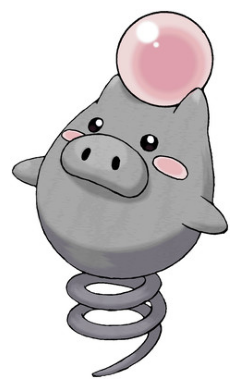

number of image:8
       Name    Type1 Type2
250  Spoink  Psychic      
	
1:relevant types:type: Steel , predicted probabilities:0.17529296875
	
2:relevant types:type: Electric , predicted probabilities:0.14794921875
	
3:relevant types:type: Psychic , predicted probabilities:0.11370849609375
	
4:relevant types:type: Fighting , predicted probabilities:0.0706787109375
	
5:relevant types:type: Fire , predicted probabilities:0.048248291015625




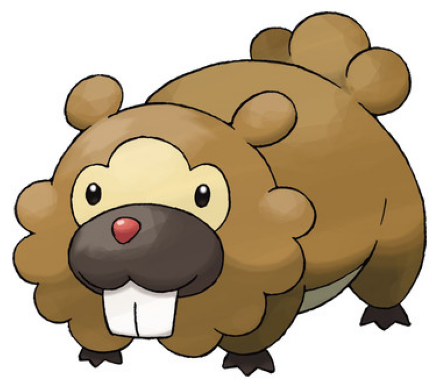

number of image:9
       Name   Type1 Type2
311  Bidoof  Normal      
	
1:relevant types:type: Normal , predicted probabilities:0.0677490234375
	
2:relevant types:type: Fighting , predicted probabilities:0.0308837890625
	
3:relevant types:type: Ground , predicted probabilities:0.02783203125
	
4:relevant types:type: Grass , predicted probabilities:0.02508544921875
	
5:relevant types:type: Dark , predicted probabilities:0.0162811279296875




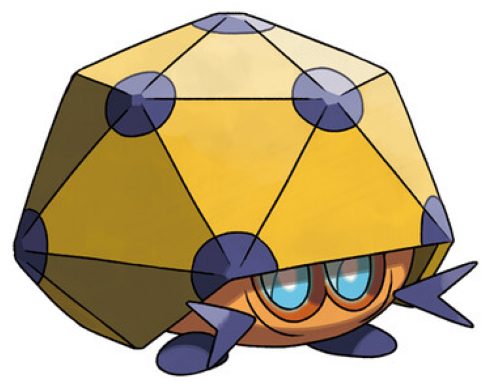

number of image:10
        Name Type1    Type2
688  Dottler   Bug  Psychic
	
1:relevant types:type: Rock , predicted probabilities:0.9384765625
	
2:relevant types:type: Bug , predicted probabilities:0.322265625
	
3:relevant types:type: Electric , predicted probabilities:0.12841796875
	
4:relevant types:type: Poison , predicted probabilities:0.0670166015625
	
5:relevant types:type: Steel , predicted probabilities:0.05963134765625




In [43]:
#Get the data frame
x=construct_pokedex()
x=x[['Name','Type1','Type2']]
x = x.sample(n=10,random_state=42)

#image path
new_image_paths = []
image_dir='./images/'
for pokemon_name in x["Name"]:
    imgs = glob(f"{image_dir}/{pokemon_name}/0.jpg")
    if len(imgs) > 0:
        new_image_paths.append(imgs[0])
    else:
        new_image_paths.append(None)

#Image embedding
model, preprocess, device = load_clip_model()
image_embeddings = clip_inference_image(model, preprocess, new_image_paths, device)


#Text embedding
text = ['type: Normal', 'type: Fire', 'type: Water', 'type: Electric',
                 'type: Grass', 'type: Ice', 'type: Fighting', 'type: Poison',
                 'type: Ground', 'type: Flying', 'type: Psychic', 'type: Bug',
                 'type: Rock', 'type: Ghost', 'type: Dark', 'type: Dragon',
                 'type: Steel', 'type: Fairy']
text_embeddings = clip_inference_text(model, preprocess, text, device)

#Compute the similarity score
similarity_matrix = compute_similarity_image_to_text(image_embeddings, text_embeddings)
#The shape of similarity_matrix is (10, 18), I think this is correct so far.

'''
Next Goals:
1.plot the picture we selected one by one
2.output real name and f/s type
3.five relevant types and predicted probabilities
'''
for i in range(10):
  #orignial image
  display_image(new_image_paths[i])

  # Get the indices of the top five elements
  top_indices = np.argsort(similarity_matrix[i])[::-1][:5]
  #array([13,  5, 10,  7, 17])

  # Get the values corresponding to the top indices
  top_values = similarity_matrix[i][top_indices]
  #array([0.794 , 0.4941, 0.431 , 0.336 , 0.326 ], dtype=float16)

  print(f"number of image:{i+1}")

  # name and type
  print(x.iloc[i:i+1])
  for j in range(5):
    print('\t')
    print(f"{j+1}:relevant types:{text[top_indices[j]]} , predicted probabilities:{top_values[j]}")
  print("\n")

### <strong>Question 28</strong>

In [44]:
# Construct dataset, specifically for type Bug, Fire, Grass and based on first type
dataset = construct_pokedex()
dataset=dataset.loc[(dataset['Type1'] == 'Bug') | (dataset['Type1'] == 'Fire') | (dataset['Type1'] == 'Grass')]

# Load CLIP model
model, preprocess, device = load_clip_model()

# Get image paths from the Pokedex
image_paths = dataset["image_path"].values

# Inference image embeddings using CLIP
image_embeddings = clip_inference_image(model, preprocess, image_paths, device)
# image_embeddings.shape:(192, 768)

#tsne_data.shape: (192, 2)
tsne_data=umap_projection(image_embeddings, n_neighbors=15, min_dist=0.1, metric='cosine')

100%|██████████| 192/192 [00:03<00:00, 49.07it/s]


In [45]:
import plotly.express as px

# Add the tsne_data to the dataset DataFrame
dataset['tsne_x'] = tsne_data[:, 0]
dataset['tsne_y'] = tsne_data[:, 1]

# Create a color dictionary for type 1
type_colors = {'Bug': 'green', 'Fire': 'red', 'Grass': 'blue'}

# Create the scatter plot using Plotly
fig = px.scatter(dataset, x='tsne_x', y='tsne_y', color='Type1', color_discrete_map=type_colors,
                 hover_name='Name', hover_data=['Type1', 'Type2'])

# Update the layout of the plot
fig.update_layout(title='t-SNE Visualization of Image Clusters for Bug, Fire, and Grass Types',
                  xaxis_title='t-SNE Dimension 1', yaxis_title='t-SNE Dimension 2')

# Show the plot
fig.show()
